In [1]:
# importing all the modules
import ast
import math
import numpy as np
import pandas as pd
import itertools
import tabula
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
try:
    import pygraphviz
    from networkx.drawing.nx_agraph import graphviz_layout
except ImportError:
    try:
        import pydot
        from networkx.drawing.nx_pydot import graphviz_layout
    except ImportError:
        raise ImportError("This example needs Graphviz and either "
                          "PyGraphviz or pydot")

In [32]:
class GRN_51142:
    
    #class attributes
    description = '''
                    A Gene Regulatory Network of Cyanothece sp. 51142 composed of literature sources. 
                    The current list of sources can be viewed by accessing the sources attribute.
                    The available functions can be viewed by accessing the methods attribute.
                  '''
    sources = '''
                 There are 3 sources at present. They are:
                     1. A model of the circadian clock in the cyanobacterium Cyanothece sp. ATCC 51142 
                         by Nguyen et. al.
                     2. A model of cyclic transcriptomic behavior in the cyanobacterium Cyanothece sp. ATCC 51142 
                         by McDermott et.al.
                     5. Identifying Regulatory Changes to Facilitate Nitrogen Fixation in the Nondiazotroph 
                         Synechocystis sp. PCC 6803 by Mueller et. al.
              '''
    
    methods = '''
                 The following methods can be accessed at present:
                     1. draw: To draw the default network and save it as GRN.png
                     2. drawNamed: To draw the default network with gene annotations and save it as nGRN.png
                     3. drawPruned: To draw a pruned network with some of the more important TF-TF/TF-TG interactions
                                    and save it as pGRN.png
                     4. drawCircadian: To draw the network with the tfs and tgs that have circadian cyclicity and save 
                                     it as cGRN.png. The clock genes/ proteins will also be there. 
                     5. drawDiurnal: To draw the network with the tfs and tgs that are under diurnal rhythm and save it
                                     as dGRN.png.
                     6. drawFiltered: This method supports predefined filter or combination of filters to draw the 
                                     model. The filters can be circadian,diurnal,light,dark,lighttodark,darktolight 
                                     or on sources. They can be implemented by passing c,d,l,da,lda or dal 
                                     respectively as attributes as a list. The attributes must be complementary. For 
                                     example adding both dark and light as filters will not output anythin at all 
                                     but adding circadian and dark or diurnal and light will. 
                     7. defineNode: Defines the function of a transcription factor or target gene if available in the 
                                     database. Expects either the ORF or the common name of the factor. 
                     8. defineEdge: Defines the source and weight on the edges. expects 2 ORFs or 2 common names.
            '''
    
    
    def __init__(self):
        ## Making the primary database
        self.GenCyanoDB = pd.read_excel("GRNCyanoDB/GenCyanoDB.xlsx",index_col=0) # from a previously created dataframe
        self.GenCyanoDB['TFTG'] = self.GenCyanoDB.TFTG.map(self.__dictparse)
        self._interdf = self.GenCyanoDB.loc[(self.GenCyanoDB.TfBool==True) & (self.GenCyanoDB.TFTG!={})] 
        self.nodes = self.__getnodes()
        self.edges = self.__getedges()
        self.G = nx.DiGraph()
        self.G.add_nodes_from(list(self.nodes))
        self.G.add_edges_from(self.edges)
        self.nndict = {i:self.GenCyanoDB.loc[self.GenCyanoDB.ORF==i]['CommonName'].values[0] for i,j in self.nodes}
        self.nnodes = [tuple([self.nndict[i],d]) for i,d in self.nodes]
        self.nedges = [tuple([self.nndict[i],self.nndict[j],w]) for i,j,w in self.edges]
        self.Gn=nx.DiGraph()
        self.Gn.add_nodes_from(list(self.nnodes))
        self.Gn.add_edges_from(self.nedges)
        self.Gp = self.__prunenet()
    
    def __dictparse(self,row):
        try:
            r = float(row)
            if math.isnan(float(row)):
                return np.nan 
        except ValueError:
            if row == '{}':
                return dict()
            else:
                return ast.literal_eval(row)
    
    def __getnodes(self):
        
        allnodes = set()
        for tf in self._interdf.loc[:,'ORF']:
            allnodes.add(tf)
            for source,interdict in self._interdf.loc[self._interdf['ORF']==tf,'TFTG'].values[0].items():
                allnodes.update(interdict.keys())
        nodeattr = [tuple([node,
                          {'Function':self.GenCyanoDB.loc[self.GenCyanoDB.ORF==node]['Function'].values[0],
                           'Cyclicity':self.GenCyanoDB.loc[self.GenCyanoDB.ORF==node]['Cyclicity'].values[0],
                           'Expression':self.GenCyanoDB.loc[self.GenCyanoDB.ORF==node]['Expression'].values[0]}])
                   for node in allnodes]
        return nodeattr
    
    def __getedges(self):
        
        alledges = list()
        for source in self._interdf.loc[:,'ORF']:
            for litsource,interdict in self._interdf.loc[self._interdf['ORF']==source,'TFTG'].values[0].items():
                wdict = [{'weight':activ,'source':litsource} for activ in interdict.values()]
                alledges.extend(tuple(zip(itertools.cycle([source]),interdict.keys(),wdict)))
        
        return alledges
    
    def __prunenet(self):
        #filter if function,cyclicity or expression is unknown
        prunednodes = [tuple([nodes,d]) for nodes,d in self.Gn.nodes(data=True) if 
                       (d['Cyclicity']!='unknown'  
                        or (d['Function']!='hypothetical protein' and d['Function']!='unknown' and d['Function']!='conserved hypothetical protein') 
                        or d['Expression']!='unknown' )] 
        edge_list = [] 
        
        nodename = [x for x,y in prunednodes]
        for edge,target,d  in self.Gn.edges(data=True):
            if edge in nodename and target in nodename:
                edge_list.append(tuple([edge,target,d]))
            if edge not in nodename and target in nodename:
                print('Yes')
                edge_list.append(tuple([edge,target,d]))
                prunednodes.append(tuple([edge,self.Gn.nodes[edge]]))
                
        
        Gp = nx.DiGraph()
        Gp.add_nodes_from(prunednodes)
        Gp.add_edges_from(edge_list) 
        
        return Gp
    
    
    
    def draw(self):       
        
        plt.figure(figsize=(35,25))

        tfnode  = [node for node in self.G.nodes if node in self._interdf.CommonName.values]
        tgnode  = [node for node in self.G.nodes if node not in self._interdf.CommonName.values]

        elarge = [(u, v) for (u, v, d) in self.G.edges(data=True) if d['weight'] > 0]
        esmall = [(u, v) for (u, v, d) in self.G.edges(data=True) if d['weight'] <= 0]

        #pos = nx.layout.spring_layout(G)
        pos = graphviz_layout(self.G, prog='dot')

        nx.draw_networkx_nodes(self.G, pos, nodelist=tfnode, with_labels=True, node_size=1050, node_color='green',
                               node_shape='p')
        nx.draw_networkx_nodes(self.G, pos, nodelist=tgnode, with_labels=True, node_size=1050, node_color='yellow',
                               node_shape='o')


        nx.draw_networkx_edges(self.G, pos, edgelist=elarge, width=3, arrows = True, arrowsize = 20,
                               arrowstyle= '->',min_source_margin=5,min_target_margin=5,edge_color='r')
        nx.draw_networkx_edges(self.G, pos, edgelist=esmall, width=3, arrows = True, edge_color='b', arrowsize = 20,
                               arrowstyle= '-[',style = 'dotted',min_source_margin=10,min_target_margin=11)

        nx.draw_networkx_labels(self.G, pos, font_size=12)

        ax = plt.gca()
        ax.set_axis_off()
        plt.tight_layout()
        plt.savefig('GRNimages/GRN.png')
        plt.show()
    
    def drawNamed(self):
        
        plt.figure(figsize=(35,25))
        
        tfnode  = [node for node in self.Gn.nodes if node in self._interdf.CommonName.values]
        tgnode  = [node for node in self.Gn.nodes if node not in self._interdf.CommonName.values]
        
        elarge = [(u, v) for (u, v, d) in self.Gn.edges(data=True) if d['weight'] > 0]
        esmall = [(u, v) for (u, v, d) in self.Gn.edges(data=True) if d['weight'] <= 0]

        #pos = nx.layout.spring_layout(G)
        pos = graphviz_layout(self.Gn, prog='dot')

        nx.draw_networkx_nodes(self.Gn, pos, nodelist=tfnode, with_labels=True, node_size=1050, node_color='green',
                               node_shape='p')
        nx.draw_networkx_nodes(self.Gn, pos, nodelist=tgnode, with_labels=True, node_size=750, node_color='yellow',
                               node_shape='o')


        nx.draw_networkx_edges(self.Gn, pos, edgelist=elarge, width=3, arrows = True, arrowsize = 20,arrowstyle= '->',
                               min_source_margin=5,min_target_margin=5,edge_color='r')
        nx.draw_networkx_edges(self.Gn, pos, edgelist=esmall, width=3, arrows = True, edge_color='b', arrowsize = 20,
                               arrowstyle= '-[',style = 'dotted',min_source_margin=10,min_target_margin=11)

        nx.draw_networkx_labels(self.Gn, pos, font_size=12)

        ax = plt.gca()
        ax.set_axis_off()
        plt.tight_layout()
        plt.savefig('GRNimages/nGRN.png')
        plt.show()
    
    
    def drawPruned(self):
        
        plt.figure(figsize=(30,20))

        tfnode  = [node for node in self.Gp.nodes if self.GenCyanoDB.loc[self.GenCyanoDB.CommonName==node]['TfBool'].values[0]]
        tgnode  = [node for node in self.Gp.nodes if not self.GenCyanoDB.loc[self.GenCyanoDB.CommonName==node]['TfBool'].values[0]]
        
        

        elarge = [(u, v) for (u, v, d) in self.Gp.edges(data=True) if d['weight'] > 0]
        esmall = [(u, v) for (u, v, d) in self.Gp.edges(data=True) if d['weight'] <= 0]

        pos = graphviz_layout(self.Gp, prog='dot')

        nx.draw_networkx_nodes(self.Gp, pos, nodelist=tfnode, with_labels=True, node_size=1050, node_color='green',
                               node_shape='p')
        nx.draw_networkx_nodes(self.Gp, pos, nodelist=tgnode, with_labels=True, node_size=1050, node_color='yellow',
                               node_shape='o')

        nx.draw_networkx_edges(self.Gp, pos, edgelist=elarge, width=2.5, arrows = True, arrowsize = 25,edge_color='r',
                               arrowstyle= '->',min_source_margin=5,min_target_margin=5)
        nx.draw_networkx_edges(self.Gp, pos, edgelist=esmall, width=2.5, arrows = True, edge_color='b', arrowsize = 25,
                               arrowstyle= '-[',style = 'dotted',min_source_margin=10,min_target_margin=11)

        nx.draw_networkx_labels(self.Gp, pos, font_size=12)

        ax = plt.gca()
        ax.set_axis_off()
        plt.tight_layout()
        plt.savefig('GRNimages/pGRN.png')
        plt.show()
        pass
    
    def drawCircadian(self):
        
        circadian_nodes = [tuple([nodes,d]) for nodes,d in self.Gp.nodes(data=True) if (d['Cyclicity']=='circadian' or 'circadian' in d['Function'])] 
        edge_list = [] 
        
        nodename = [x for x,y in circadian_nodes]
        for edge,target,d  in self.Gp.edges(data=True):
            if edge in nodename and target in nodename:
                edge_list.append(tuple([edge,target,d]))
            if edge in nodename and target not in nodename:
                edge_list.append(tuple([edge,target,d]))
                circadian_nodes.append(tuple([target,self.Gp.nodes[target]]))
            if edge not in nodename and target in nodename:
                edge_list.append(tuple([edge,target,d]))
                circadian_nodes.append(tuple([edge,self.Gp.nodes[edge]]))
                
        
        Gc = nx.DiGraph()
        Gc.add_nodes_from(circadian_nodes)
        Gc.add_edges_from(edge_list)
        
        plt.figure(figsize=(30,15))
        tfnode  = [node for node in Gc.nodes if self.GenCyanoDB.loc[self.GenCyanoDB.CommonName==node]['TfBool'].values[0]]
        tgnode  = [node for node in Gc.nodes if not self.GenCyanoDB.loc[self.GenCyanoDB.CommonName==node]['TfBool'].values[0]]
        

        elarge = [(u, v) for (u, v, d) in Gc.edges(data=True) if d['weight'] > 0]
        esmall = [(u, v) for (u, v, d) in Gc.edges(data=True) if d['weight'] <= 0]

        pos = graphviz_layout(Gc, prog='dot')

        nx.draw_networkx_nodes(Gc, pos, nodelist=tfnode, with_labels=True, node_size=1200, node_shape='p', 
                               node_color='green')
        nx.draw_networkx_nodes(Gc, pos, nodelist=tgnode, with_labels=True, node_size=1200, node_shape='o', 
                               node_color='yellow')

        nx.draw_networkx_edges(Gc, pos, edgelist=elarge, width=3, arrows = True, edge_color='r', arrowsize = 20,
                               arrowstyle= '->',min_source_margin=5,min_target_margin=5)
        nx.draw_networkx_edges(Gc, pos, edgelist=esmall, width=3, arrows = True, edge_color='b', arrowsize = 20,
                               arrowstyle= '-[',style = 'dotted',min_source_margin=10,min_target_margin=11)

        nx.draw_networkx_labels(Gc, pos, font_size=12)
        nx.write_graphml(Gc, 'Gc.xml')
        
        ax = plt.gca()
        ax.set_axis_off()
        plt.tight_layout()
        plt.savefig('GRNimages/cGRN.png')
        plt.show()
        return Gc
        
    
    def drawDiurnal(self):

        diurnal_nodes = [tuple([nodes,d]) for nodes,d in self.Gp.nodes(data=True) if d['Cyclicity']=='diurnal'] 
        edge_list = [] 
        nodename = [x for x,y in diurnal_nodes]
        for edge,target,d  in self.Gp.edges(data=True):
            if edge in nodename and target in nodename:
                edge_list.append(tuple([edge,target,d]))
            if edge in nodename and target not in nodename:
                edge_list.append(tuple([edge,target,d]))
                diurnal_nodes.append(tuple([target,self.Gp.nodes[target]]))
            if edge not in nodename and target in nodename:
                edge_list.append(tuple([edge,target,d]))
                diurnal_nodes.append(tuple([edge,self.Gp.nodes[edge]]))
                
        
        Gd = nx.DiGraph()
        Gd.add_nodes_from(diurnal_nodes)
        Gd.add_edges_from(edge_list)
        
        tfnode  = [node for node in Gd.nodes if self.GenCyanoDB.loc[self.GenCyanoDB.CommonName==node]['TfBool'].values[0]]
        tgnode  = [node for node in Gd.nodes if not self.GenCyanoDB.loc[self.GenCyanoDB.CommonName==node]['TfBool'].values[0]]


        plt.figure(figsize=(30,20))
        

        elarge = [(u, v) for (u, v, d) in Gd.edges(data=True) if d['weight'] > 0]
        esmall = [(u, v) for (u, v, d) in Gd.edges(data=True) if d['weight'] <= 0]

        pos = graphviz_layout(Gd, prog='dot')

        nx.draw_networkx_nodes(Gd, pos, nodelist=tfnode, with_labels=True, node_size=1200, node_shape='p', 
                               node_color='green')
        nx.draw_networkx_nodes(Gd, pos, nodelist=tgnode, with_labels=True, node_size=1200, node_shape='o', 
                               node_color='yellow')


        nx.draw_networkx_edges(Gd, pos, edgelist=elarge, width=3, arrows = True, arrowsize = 20, edge_color='r',
                               arrowstyle= '->',min_source_margin=5,min_target_margin=5)
        nx.draw_networkx_edges(Gd, pos, edgelist=esmall, width=3, arrows = True, edge_color='b', arrowsize = 20,
                               arrowstyle= '-[',style = 'dotted',min_source_margin=10,min_target_margin=11)

        nx.draw_networkx_labels(Gd, pos, font_size=12)

        ax = plt.gca()
        ax.set_axis_off()
        plt.tight_layout()
        plt.savefig('GRNimages/dGRN.png')
        plt.show()
        return Gd
        
    
    def drawFiltered(self,filters = []):
        if not filters:
            return self.drawPruned()
        else:
            filterdictCyc = {'c':'circadian','d':'diurnal'}
            filterdictExp = {'l':'L','da':'D','dal':'D to L','lda':'L to D'}
            filterdictPath = {}
            openlist = '[tuple([nodes,d]) for nodes,d in self.Gp.nodes(data=True) '
            closelist = ']'
            condition  = ''
            for f in filters:
                if not condition:
                    if f in filterdictCyc.keys():
                        condition += f'if d["Cyclicity"]=="{filterdictCyc[f]}"'
                    elif f in filterdictExp.keys():
                        condition += f'if d["Expression"]=="{filterdictExp[f]}"'
                    else:
                        raise ValueError('Incorrect Filter Value')
                else:
                    if f in filterdictCyc.keys():
                        condition += f' if d["Cyclicity"]=="{filterdictCyc[f]}"'
                    elif f in filterdictExp.keys():
                        condition += f' if d["Expression"]=="{filterdictExp[f]}"'
                    else:
                        raise ValueError('Incorrect Filter Value')
            thelist = openlist+condition+closelist
            filtered_nodes = eval(thelist)
            edge_list = [] 
            nodename = [x for x,y in filtered_nodes]
            for edge,target,d  in self.Gp.edges(data=True):
                if edge in nodename and target in nodename:
                    edge_list.append(tuple([edge,target,d]))
                if edge in nodename and target not in nodename:
                    edge_list.append(tuple([edge,target,d]))
                    filtered_nodes.append(tuple([target,self.Gp.nodes[target]]))
                if edge not in nodename and target in nodename:
                    edge_list.append(tuple([edge,target,d]))
                    filtered_nodes.append(tuple([edge,self.Gp.nodes[edge]]))


            Gf = nx.DiGraph()
            Gf.add_nodes_from(filtered_nodes)
            Gf.add_edges_from(edge_list)

            tfnode  = [node for node in Gf.nodes if node in self._interdf.CommonName.values]
            tgnode  = [node for node in Gf.nodes if node not in self._interdf.CommonName.values]


            plt.figure(figsize=(30,20))


            elarge = [(u, v) for (u, v, d) in Gf.edges(data=True) if d['weight'] > 0]
            esmall = [(u, v) for (u, v, d) in Gf.edges(data=True) if d['weight'] <= 0]

            pos = graphviz_layout(Gf, prog='dot')

            nx.draw_networkx_nodes(Gf, pos, nodelist=tfnode, with_labels=True, node_size=1200, node_shape='p', 
                                   node_color='green')
            nx.draw_networkx_nodes(Gf, pos, nodelist=tgnode, with_labels=True, node_size=1200, node_shape='o', 
                                   node_color='yellow')


            nx.draw_networkx_edges(Gf, pos, edgelist=elarge, width=3, arrows = True, arrowsize = 20, edge_color='r',
                                   arrowstyle= '->',min_source_margin=5,min_target_margin=5)
            nx.draw_networkx_edges(Gf, pos, edgelist=esmall, width=3, arrows = True, edge_color='b', arrowsize = 20,
                                   arrowstyle= '-[',style = 'dotted',min_source_margin=10,min_target_margin=11)

            nx.draw_networkx_labels(Gf, pos, font_size=12)

            ax = plt.gca()
            ax.set_axis_off()
            plt.tight_layout()
            plt.savefig('GRNimages/fGRN.png')
            plt.show()
            return Gf
    
    def defineNode(self,name):
        return self.Gn.nodes[name]

    
    def defineEdge(self,name1,name2):
        return self.Gn.edges[(name1,name2)]


In [33]:
grn = GRN_51142()

/Users/dzb5732/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/dzb5732/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


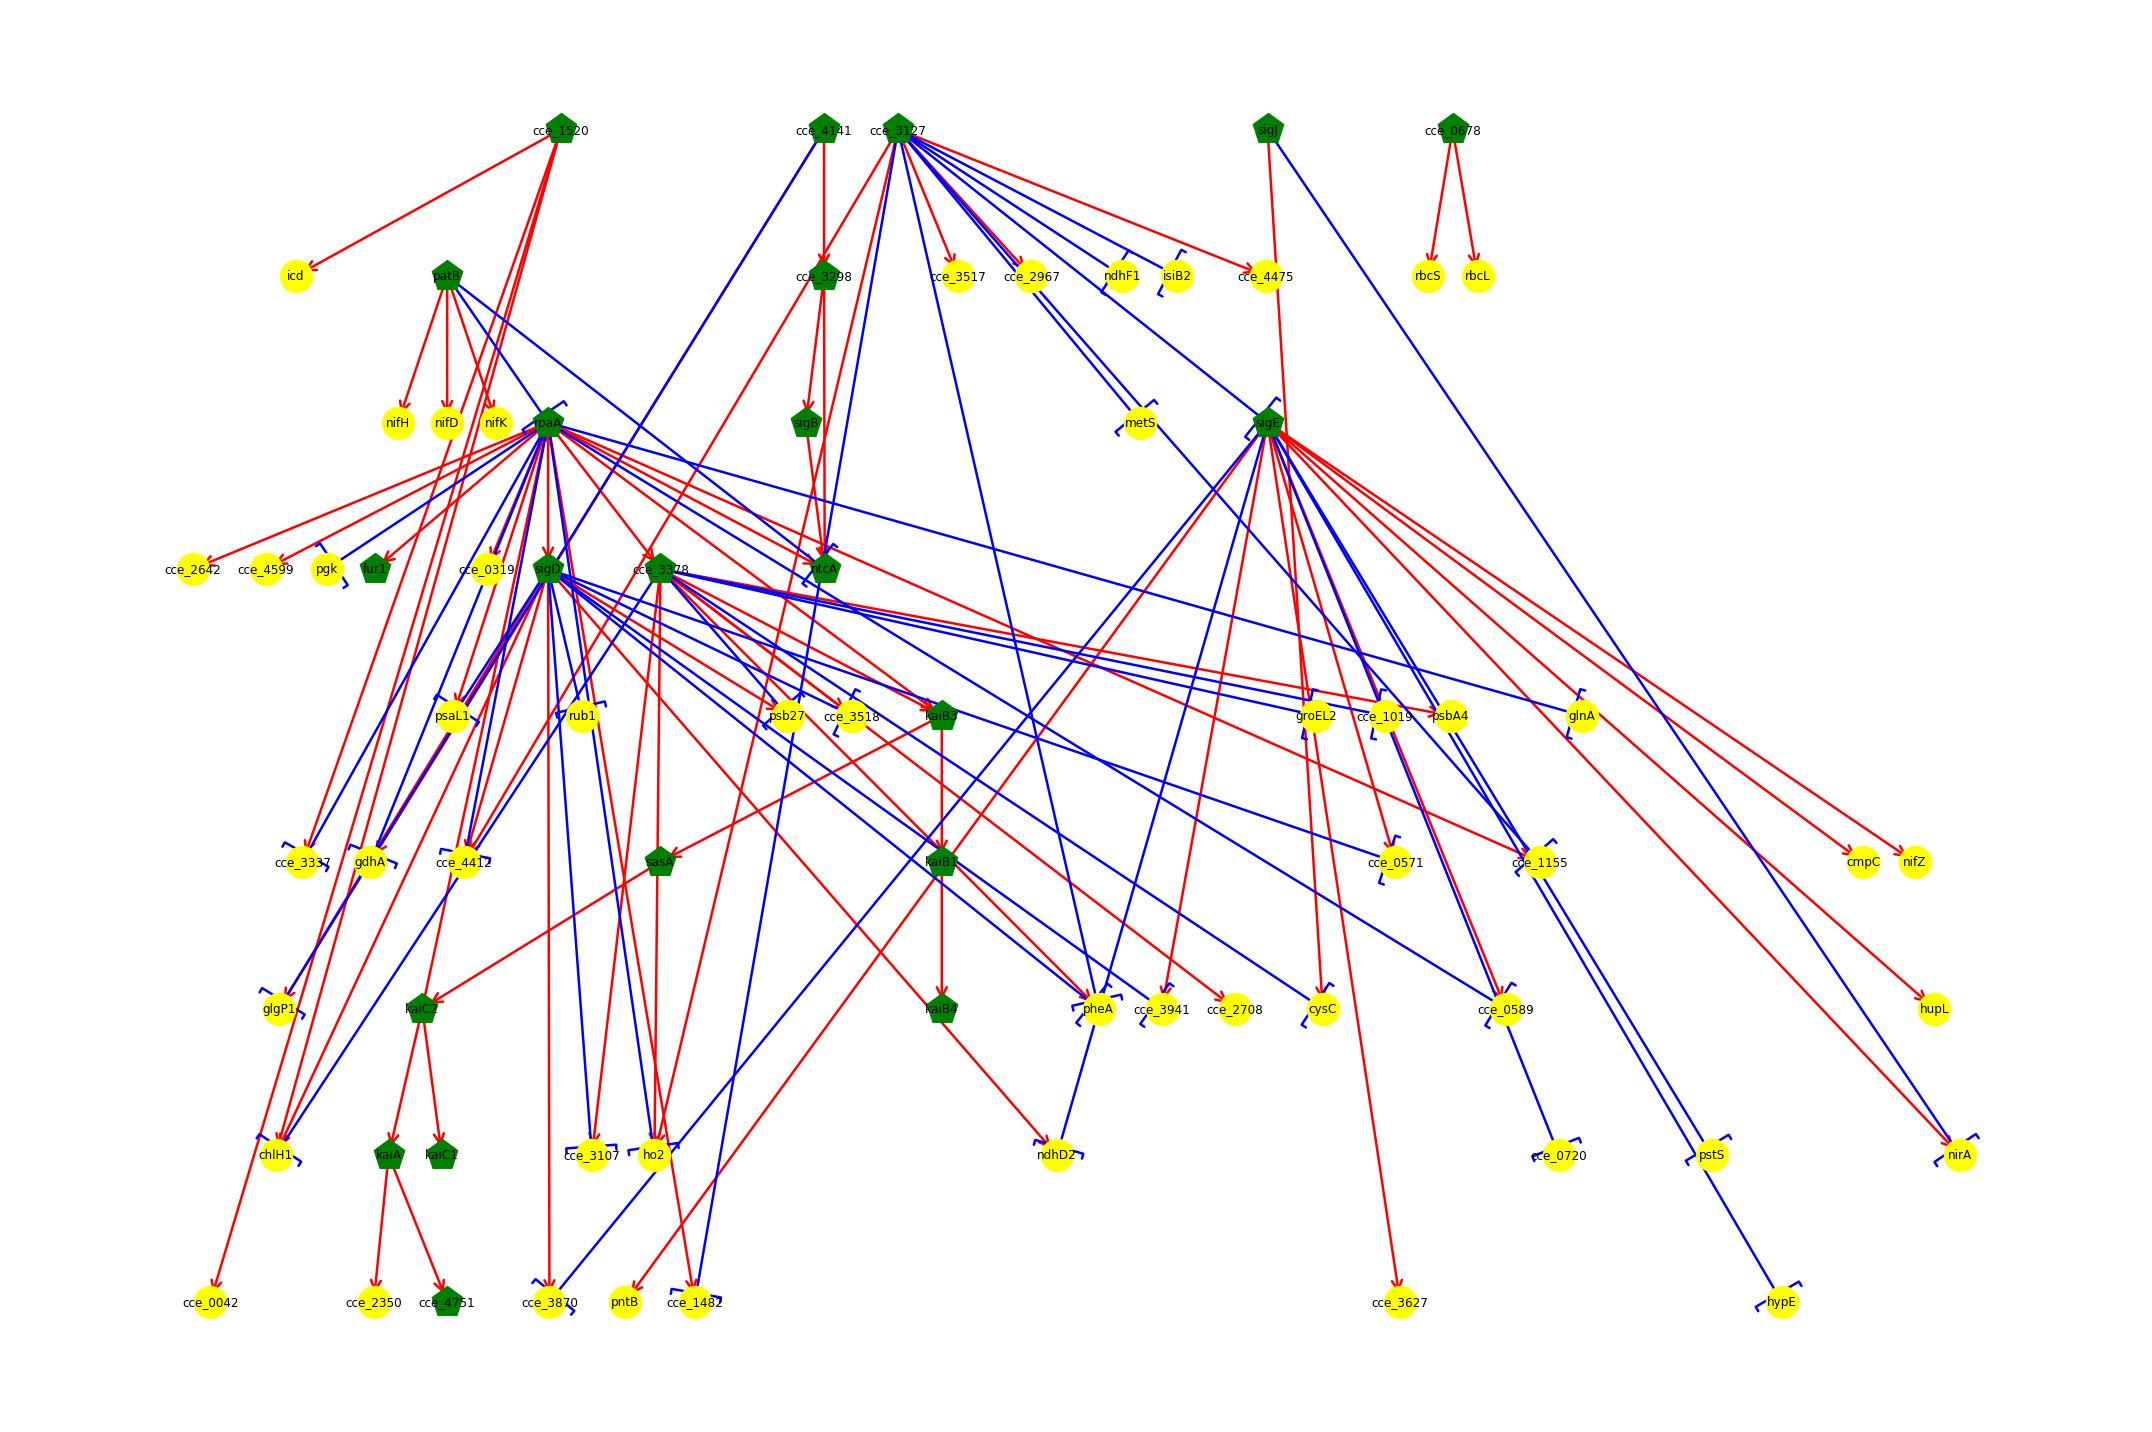

In [34]:
grn.drawPruned()

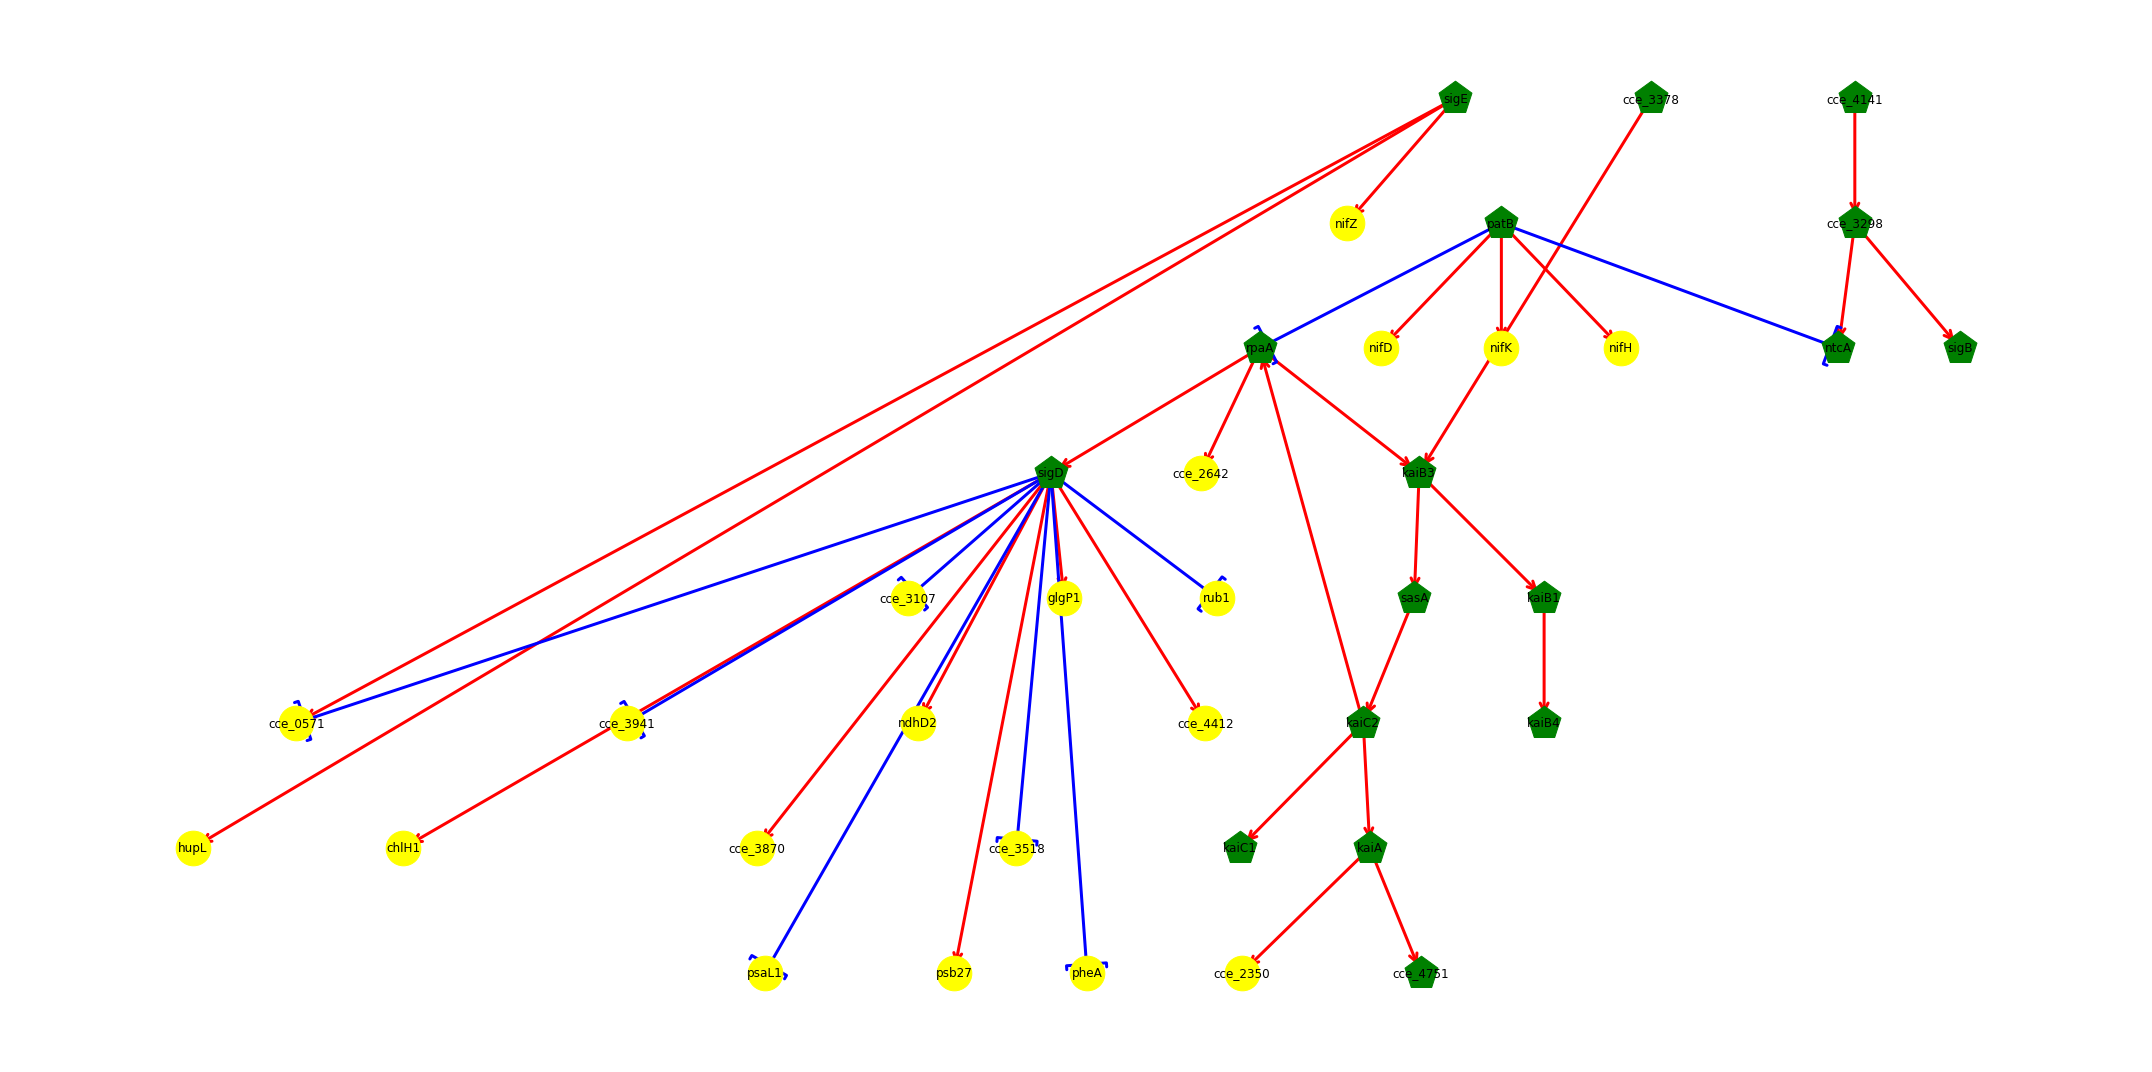

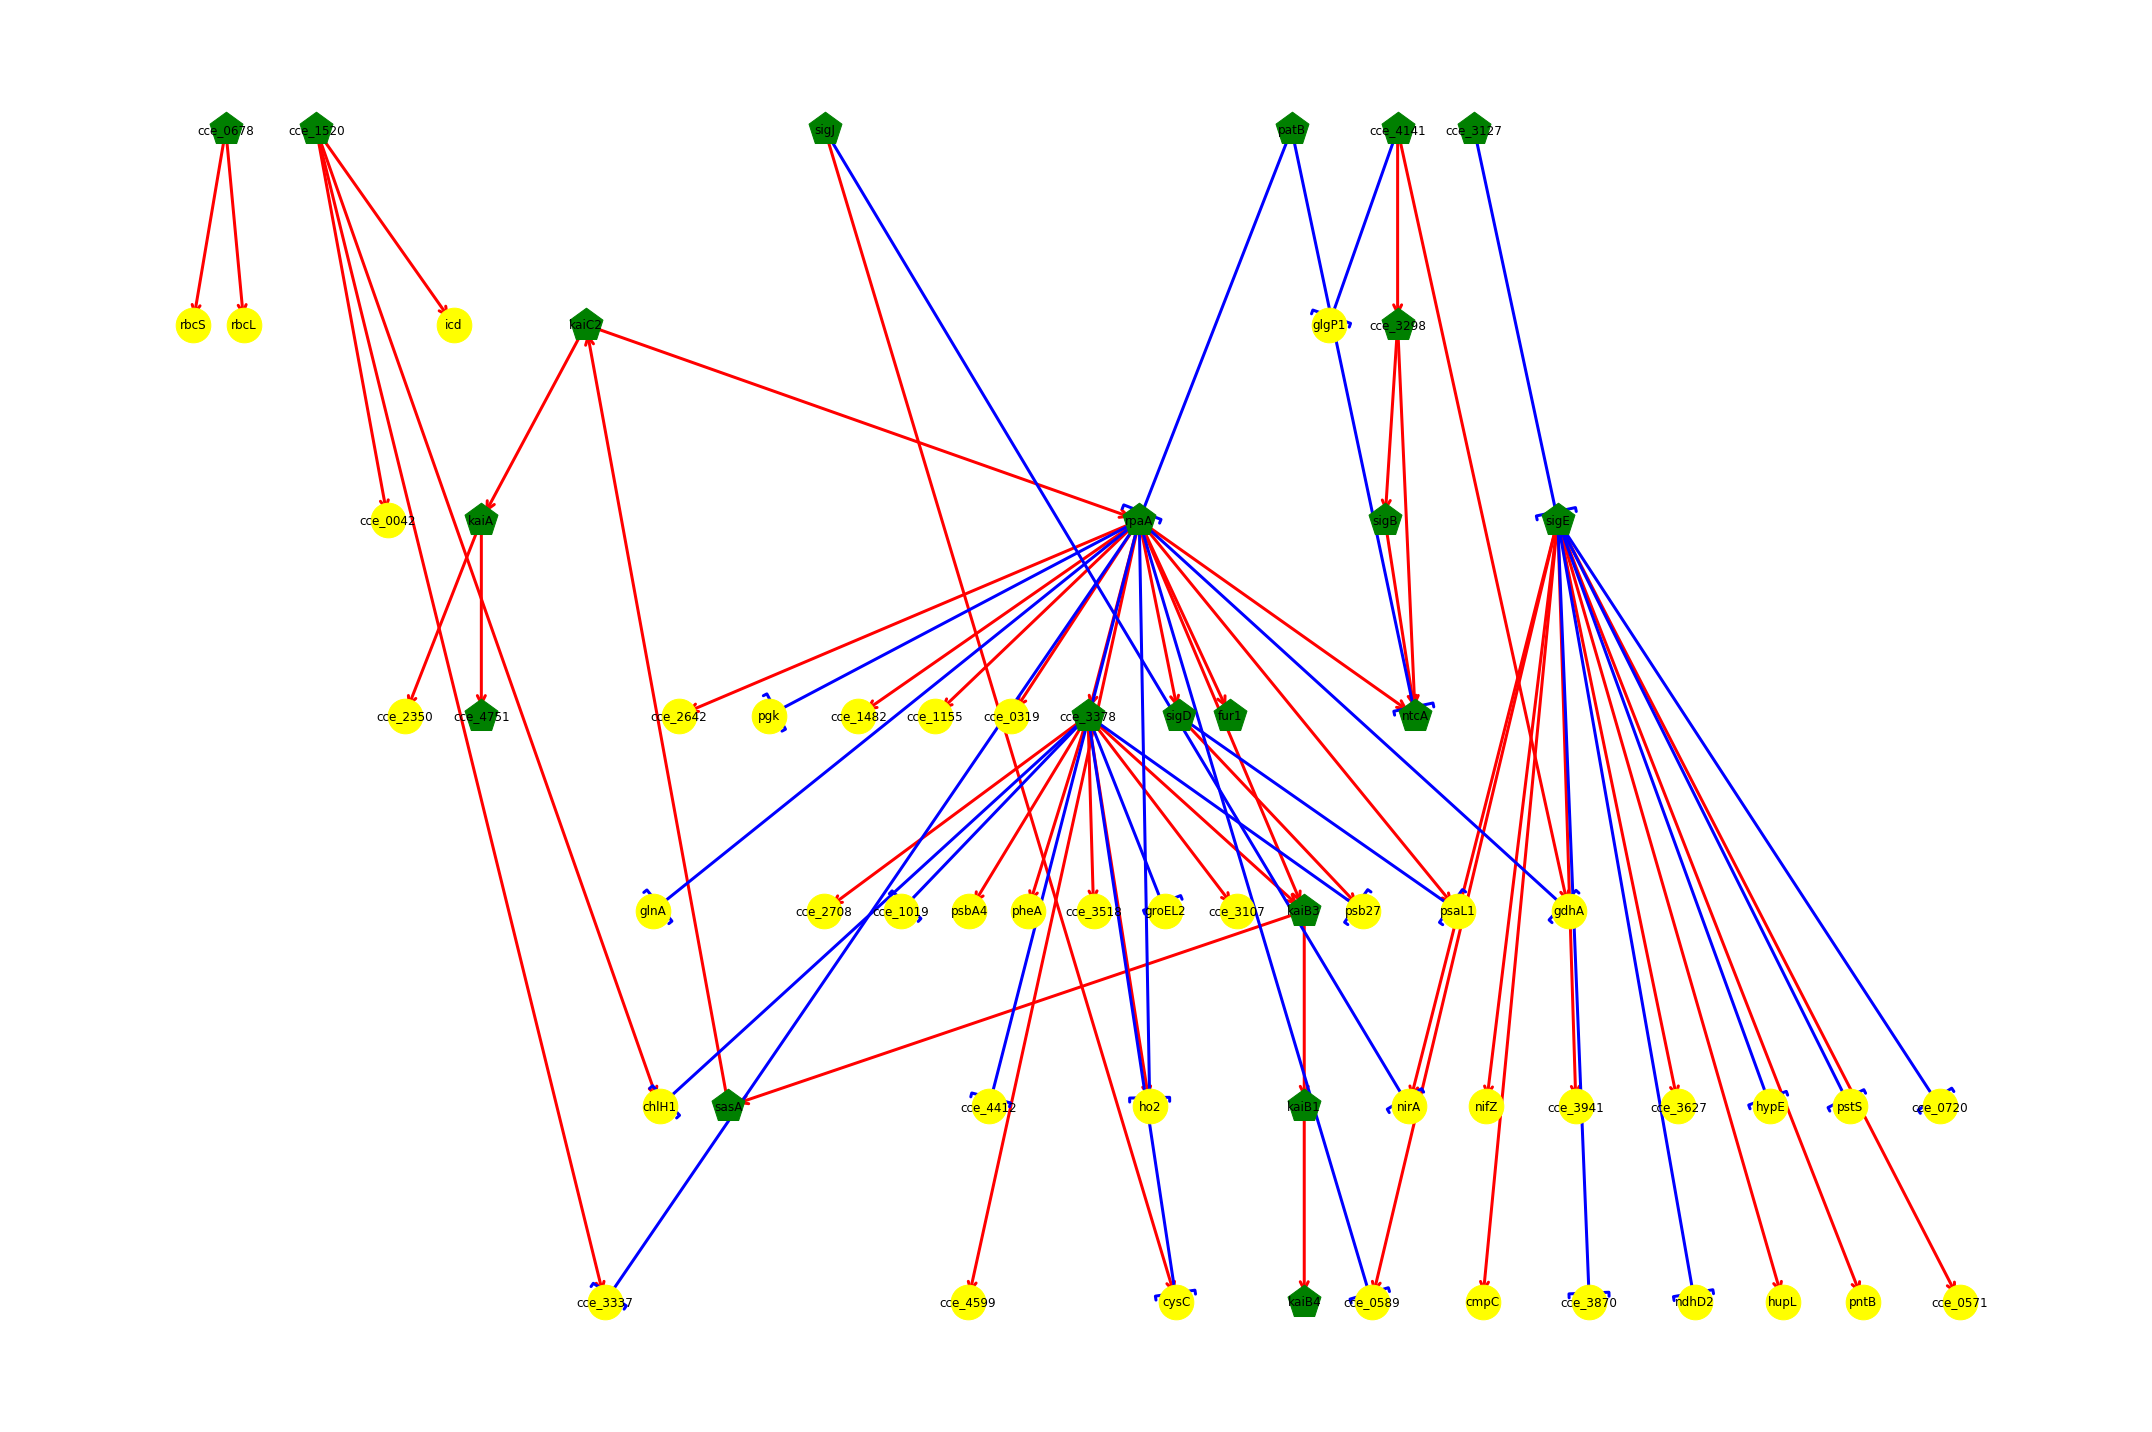

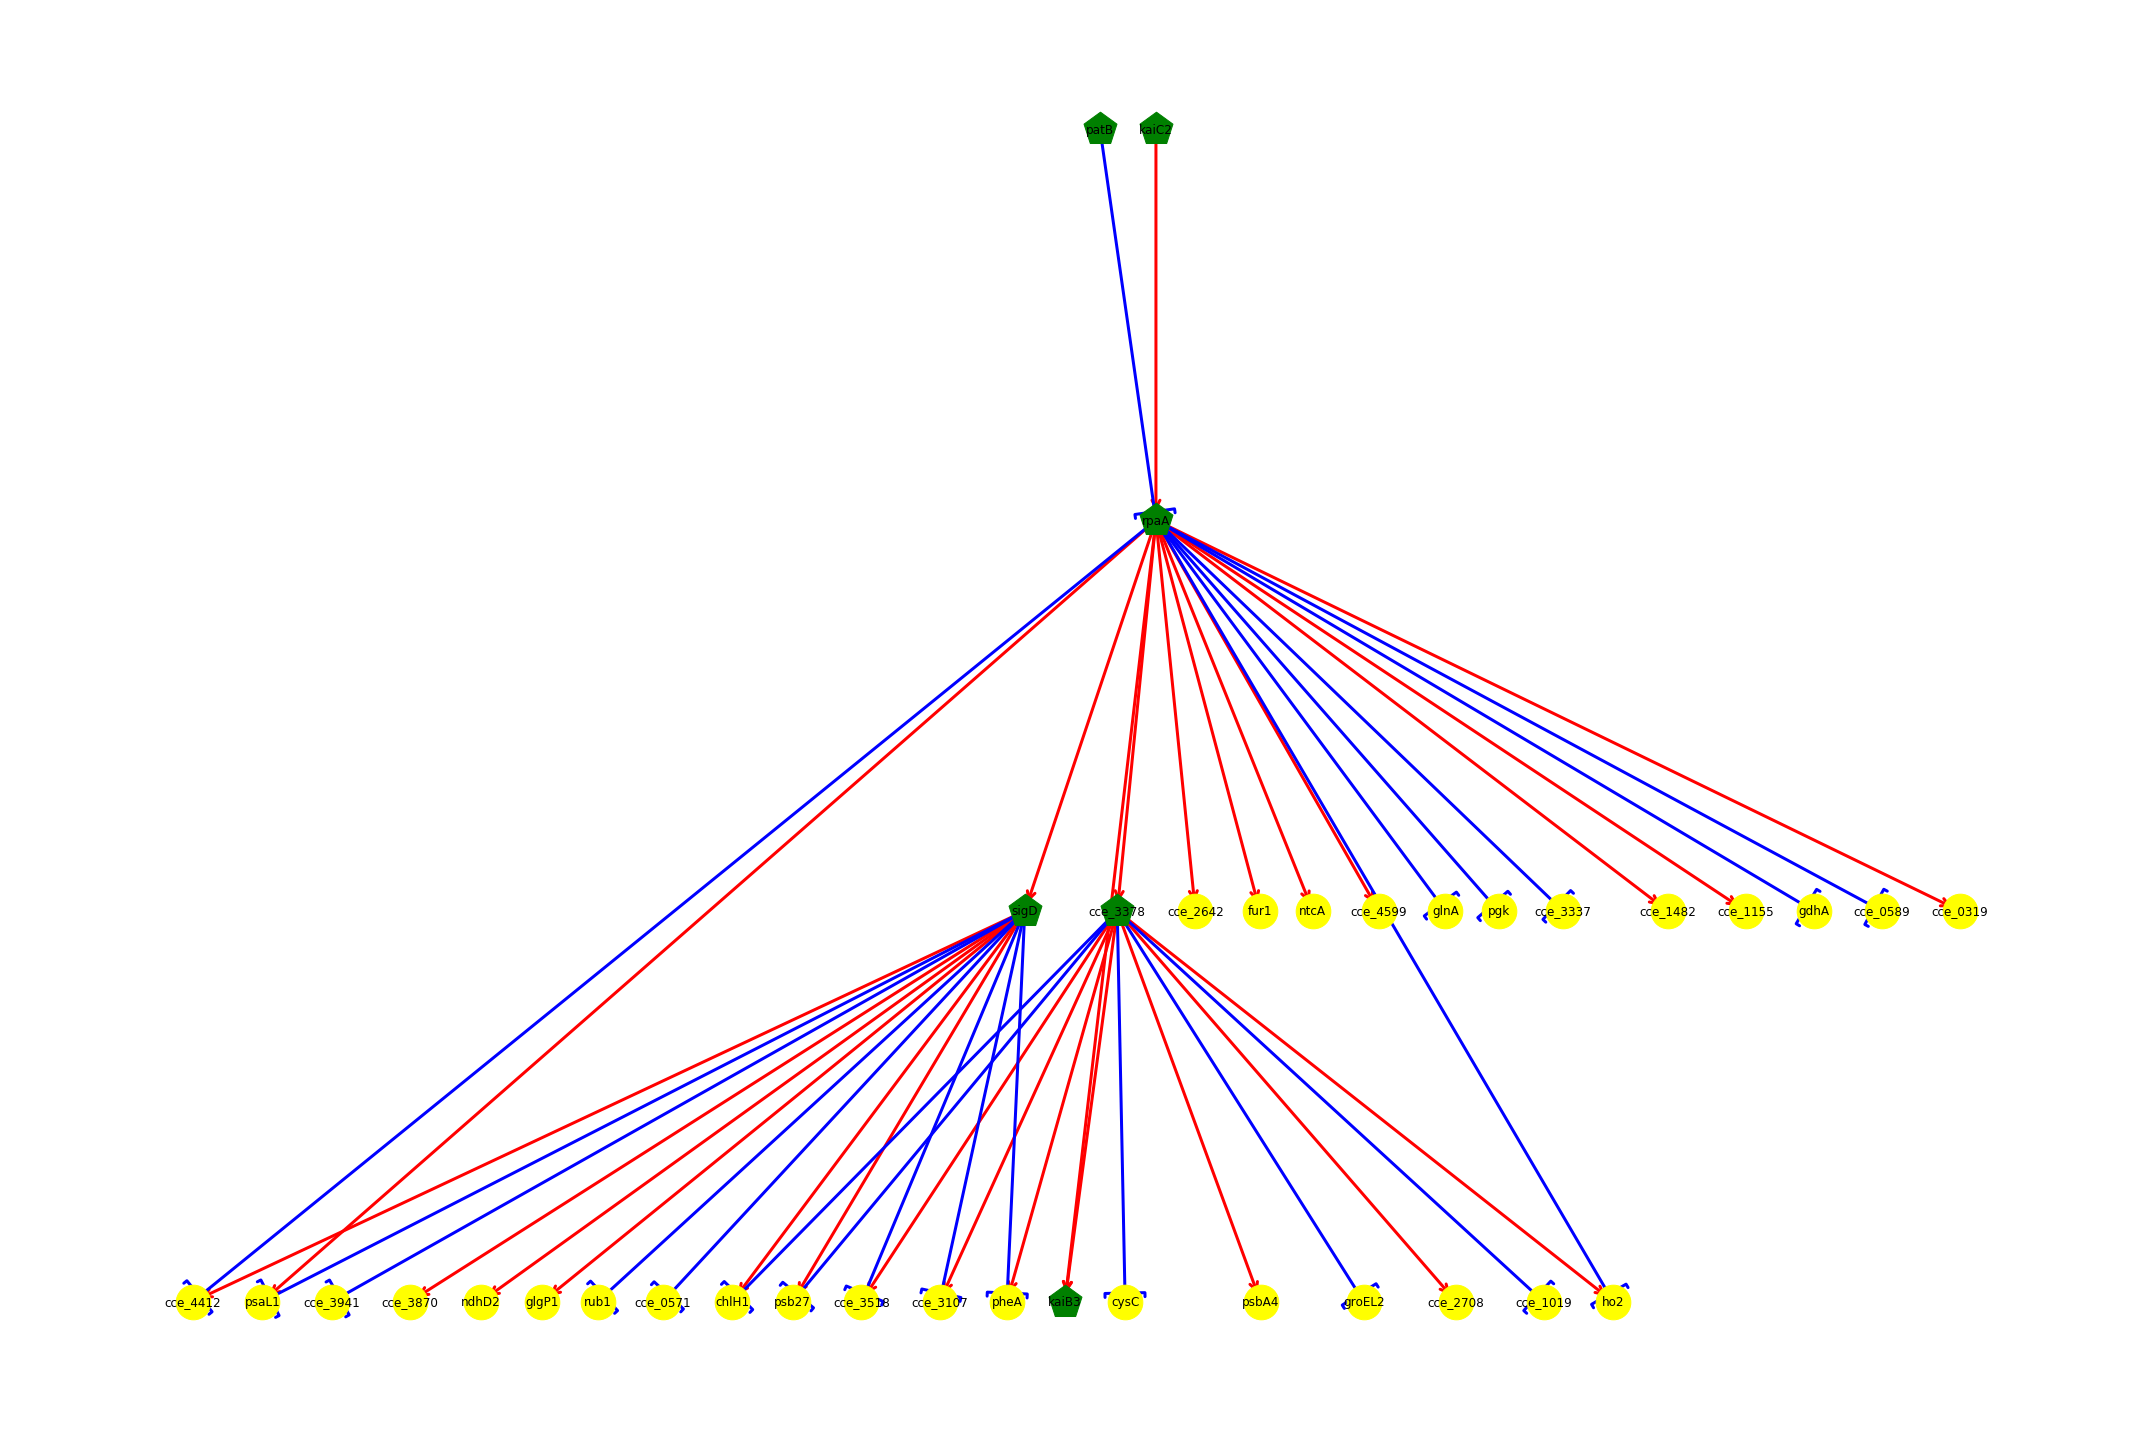

In [35]:
grnGc = grn.drawCircadian()
grnGd = grn.drawDiurnal()
grnGf = grn.drawFiltered(['lda'])

In [13]:
from pandas.plotting import table 

In [14]:
grnGf.nodes

NodeView(('sigD', 'rpaA', 'cce_3378', 'patB', 'pheA', 'cce_4412', 'chlH1', 'psaL1', 'cce_3941', 'cce_3870', 'psb27', 'ndhD2', 'cce_3518', 'cce_3107', 'glgP1', 'rub1', 'cce_0571', 'kaiC2', 'kaiB3', 'cce_2642', 'fur1', 'ntcA', 'cce_4599', 'glnA', 'pgk', 'cce_3337', 'ho2', 'cce_1482', 'cce_1155', 'gdhA', 'cce_0589', 'cce_0319', 'cysC', 'psbA4', 'groEL2', 'cce_2708', 'cce_1019'))

In [15]:
dfp = grn.GenCyanoDB.loc[grn.GenCyanoDB.CommonName.isin(list(grn.Gp.nodes))][['CommonName','Function','pathway']]
dfc = grn.GenCyanoDB.loc[grn.GenCyanoDB.CommonName.isin(list(grnGc.nodes))][['CommonName','Function','pathway']]
dfd = grn.GenCyanoDB.loc[grn.GenCyanoDB.CommonName.isin(list(grnGd.nodes))][['CommonName','Function','pathway']]
dff = grn.GenCyanoDB.loc[grn.GenCyanoDB.CommonName.isin(list(grnGf.nodes))][['CommonName','Function','pathway']]

In [16]:
dfp1 = dfp.iloc[:37]
dfp2 = dfp.iloc[37:]

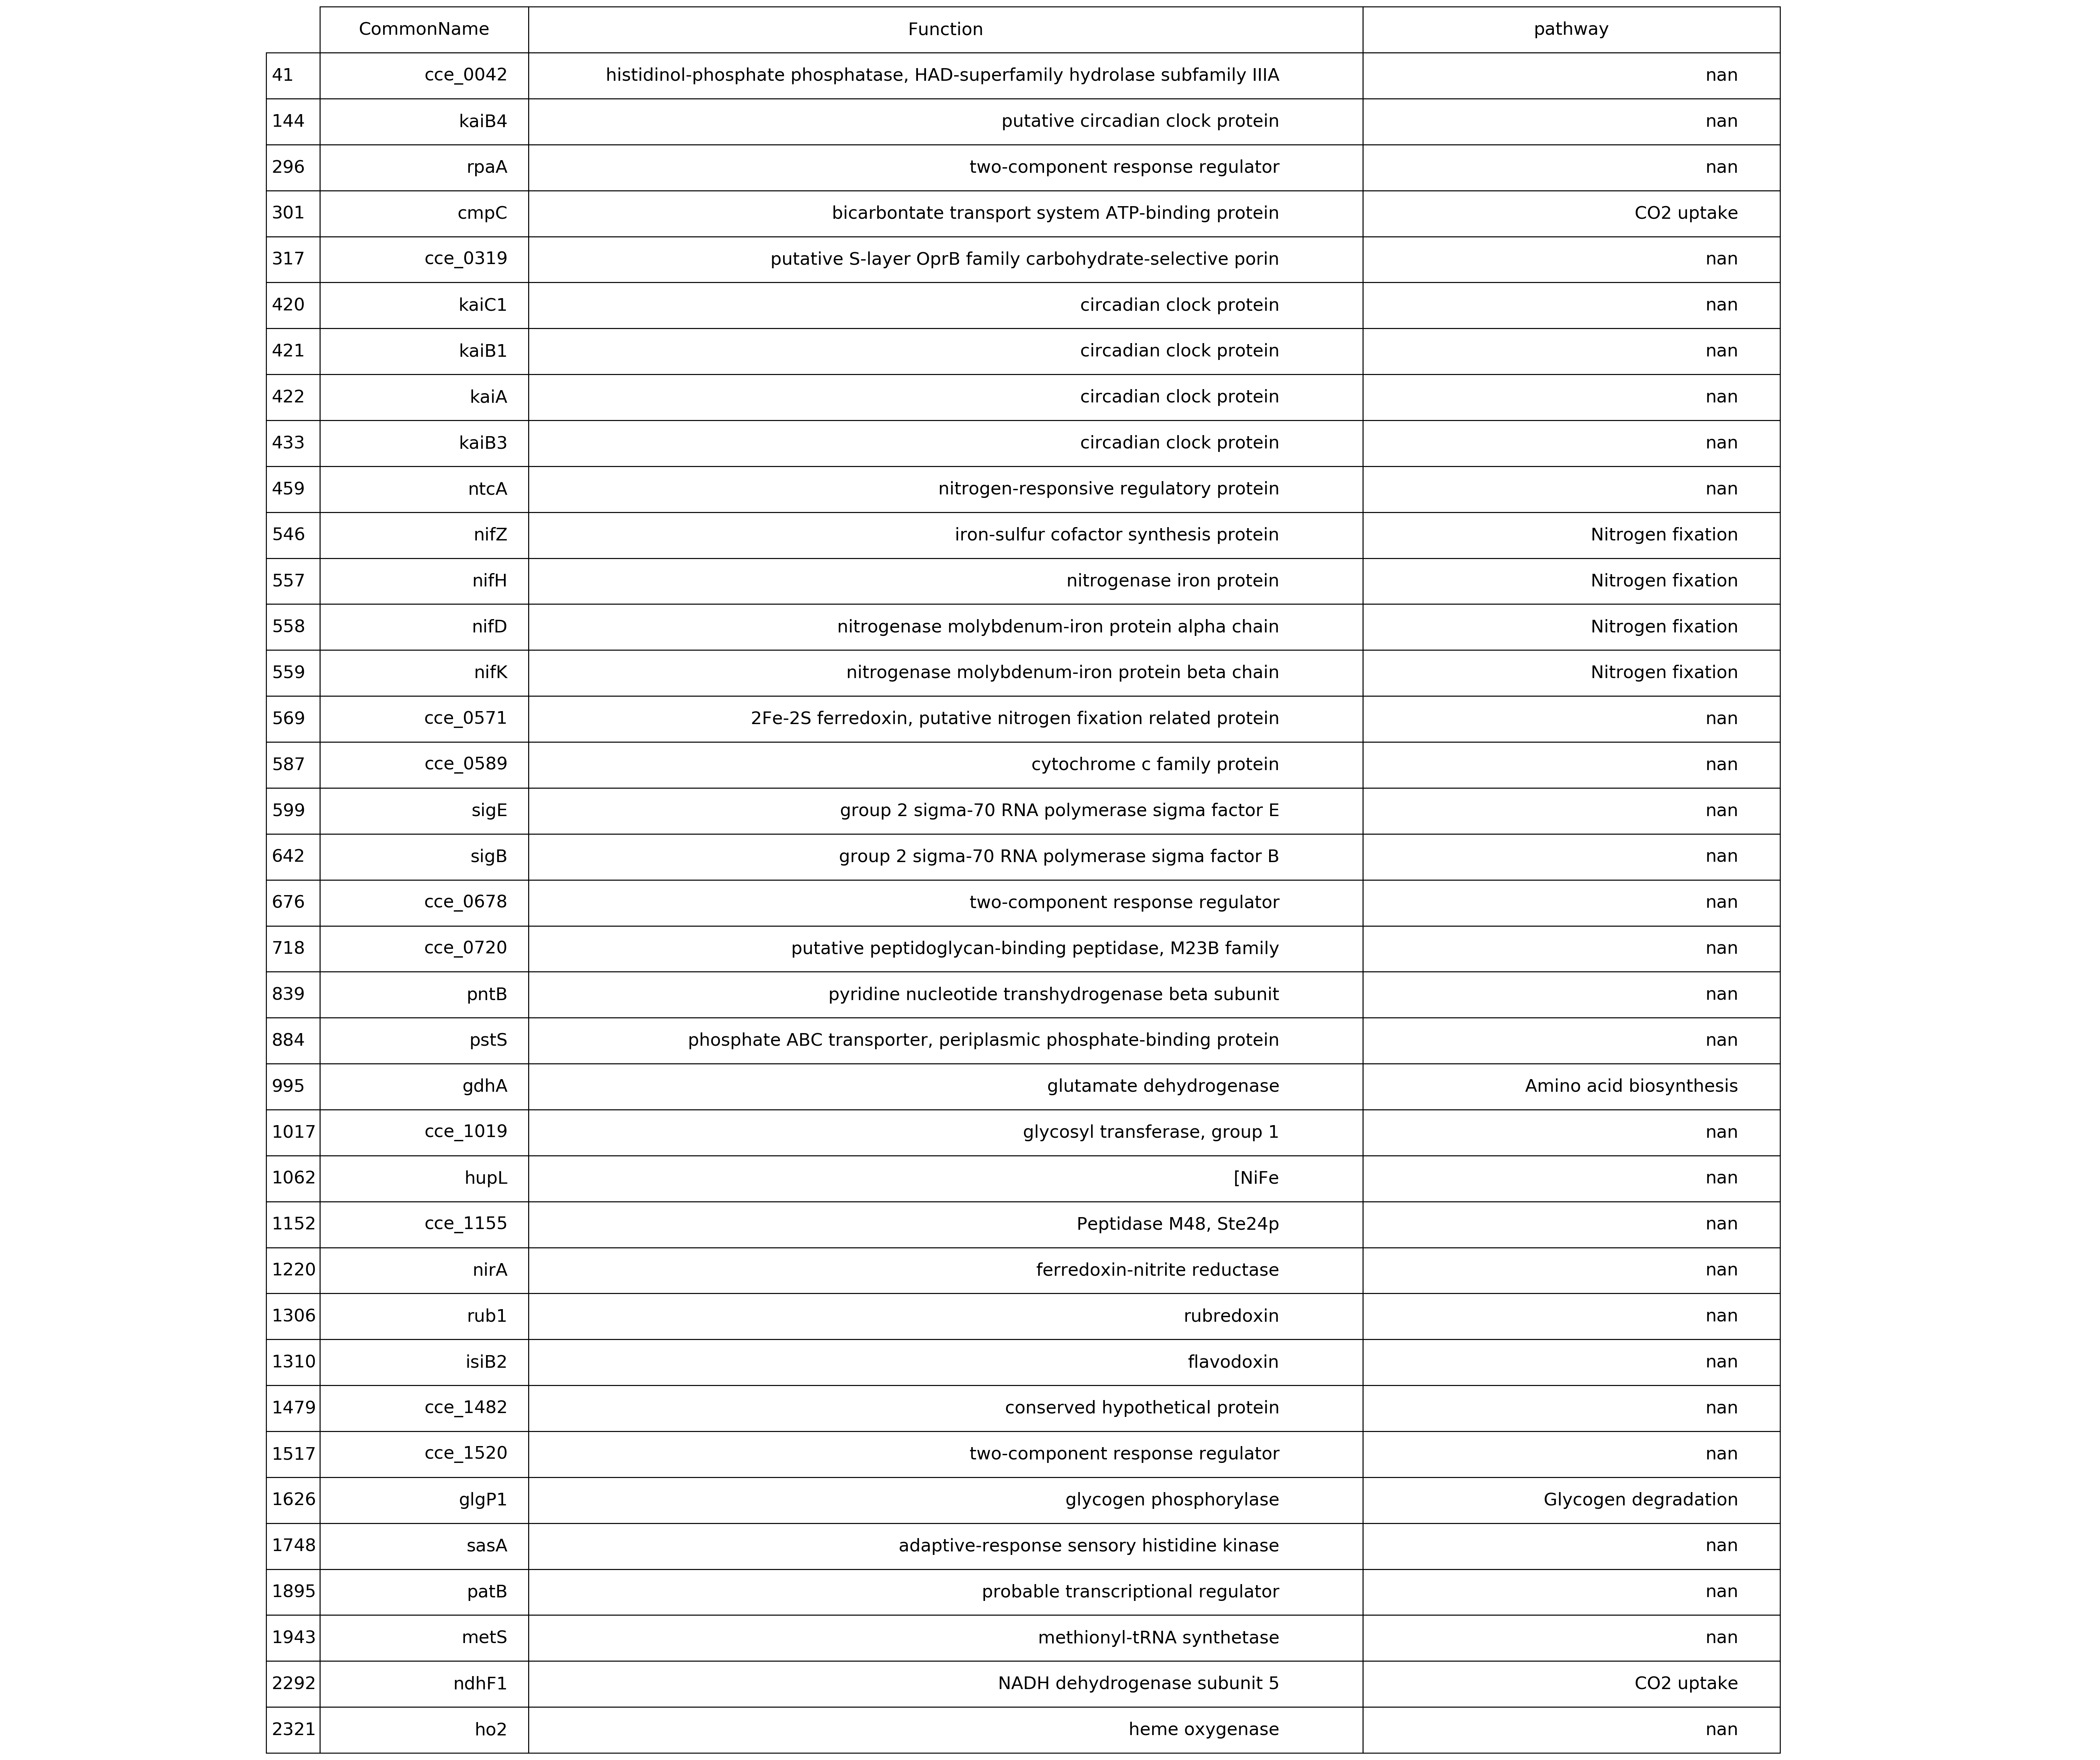

In [17]:
fig = plt.figure(figsize = (30,25),dpi=200)
ax = plt.subplot(111,frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
ax.axis('tight')
tab = table(ax, dfp1,loc='center',colWidths=[0.05, 0.2, 0.1])  # where df is your data frame
tab.set_fontsize(45)
tab.scale(2,3)

plt.tight_layout()
plt.savefig('GRNimages/pGRNtable1.png',bbox_inches = 'tight')

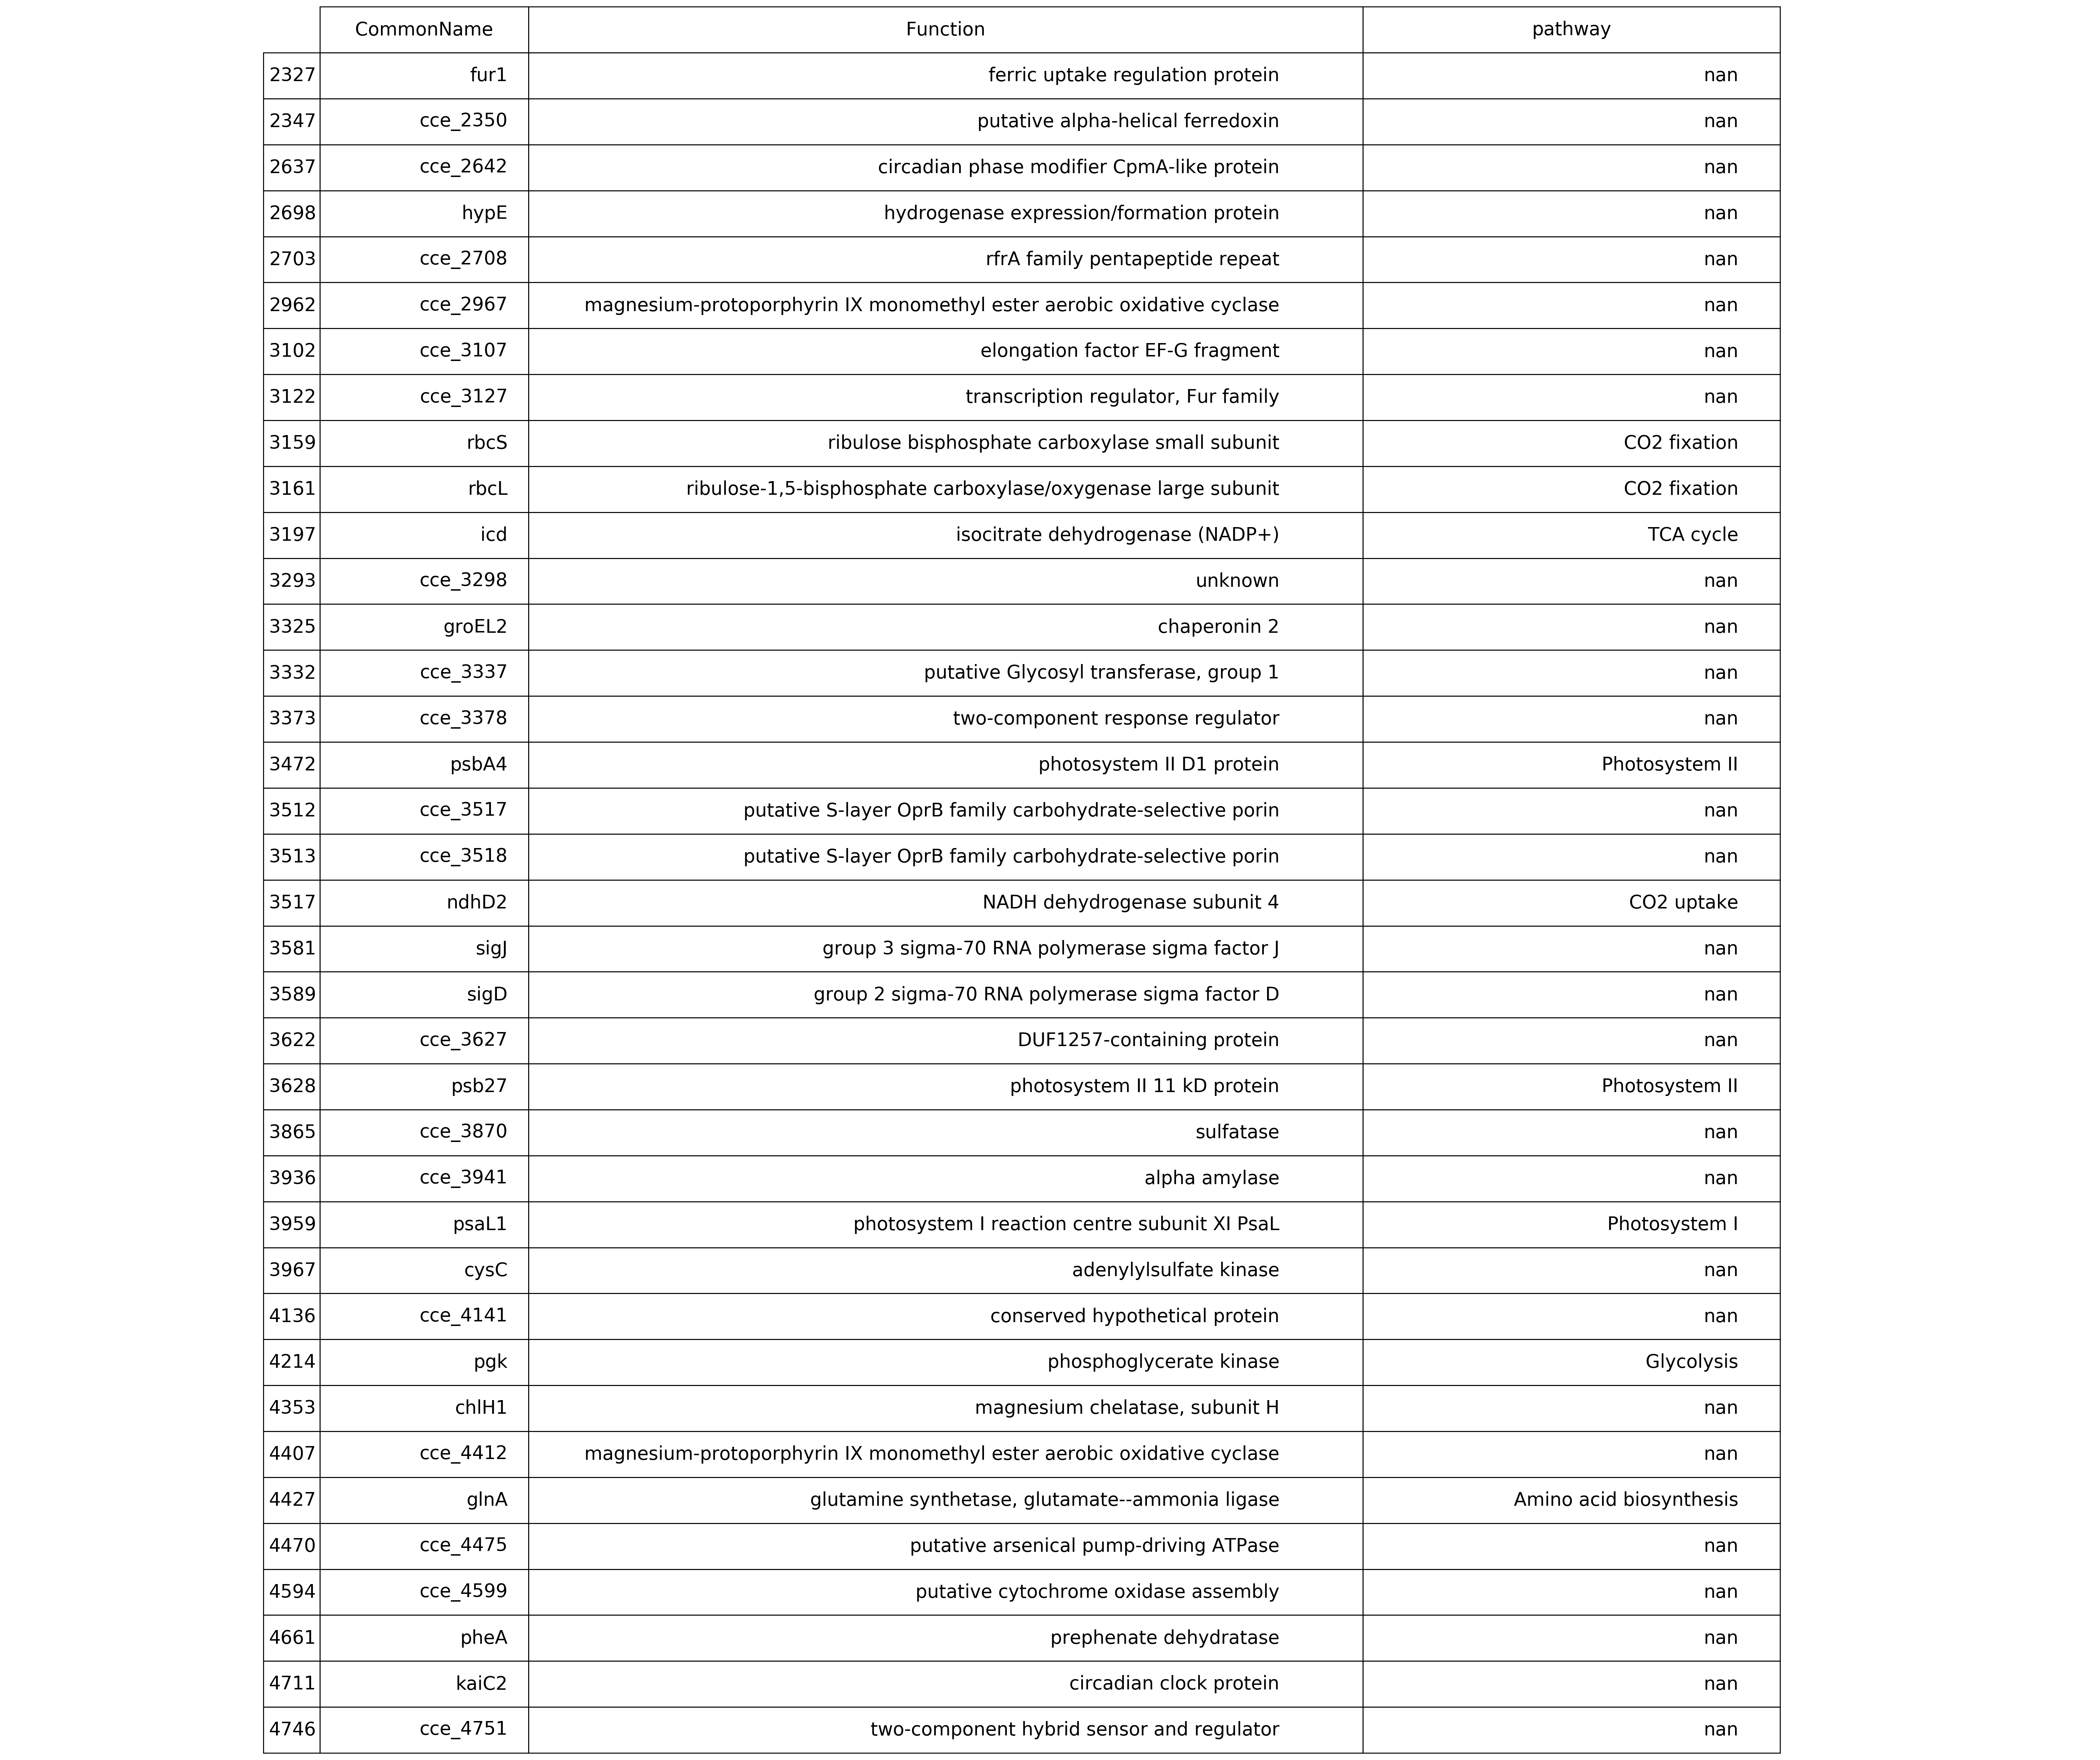

In [18]:
fig = plt.figure(figsize = (30,25),dpi=200)
ax = plt.subplot(111,frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
ax.axis('tight')
tab = table(ax, dfp2,loc='center',colWidths=[0.05, 0.2, 0.1])  # where df is your data frame
tab.set_fontsize(45)
tab.scale(2,3)

plt.tight_layout()
plt.savefig('GRNimages/pGRNtable2.png',bbox_inches = 'tight')

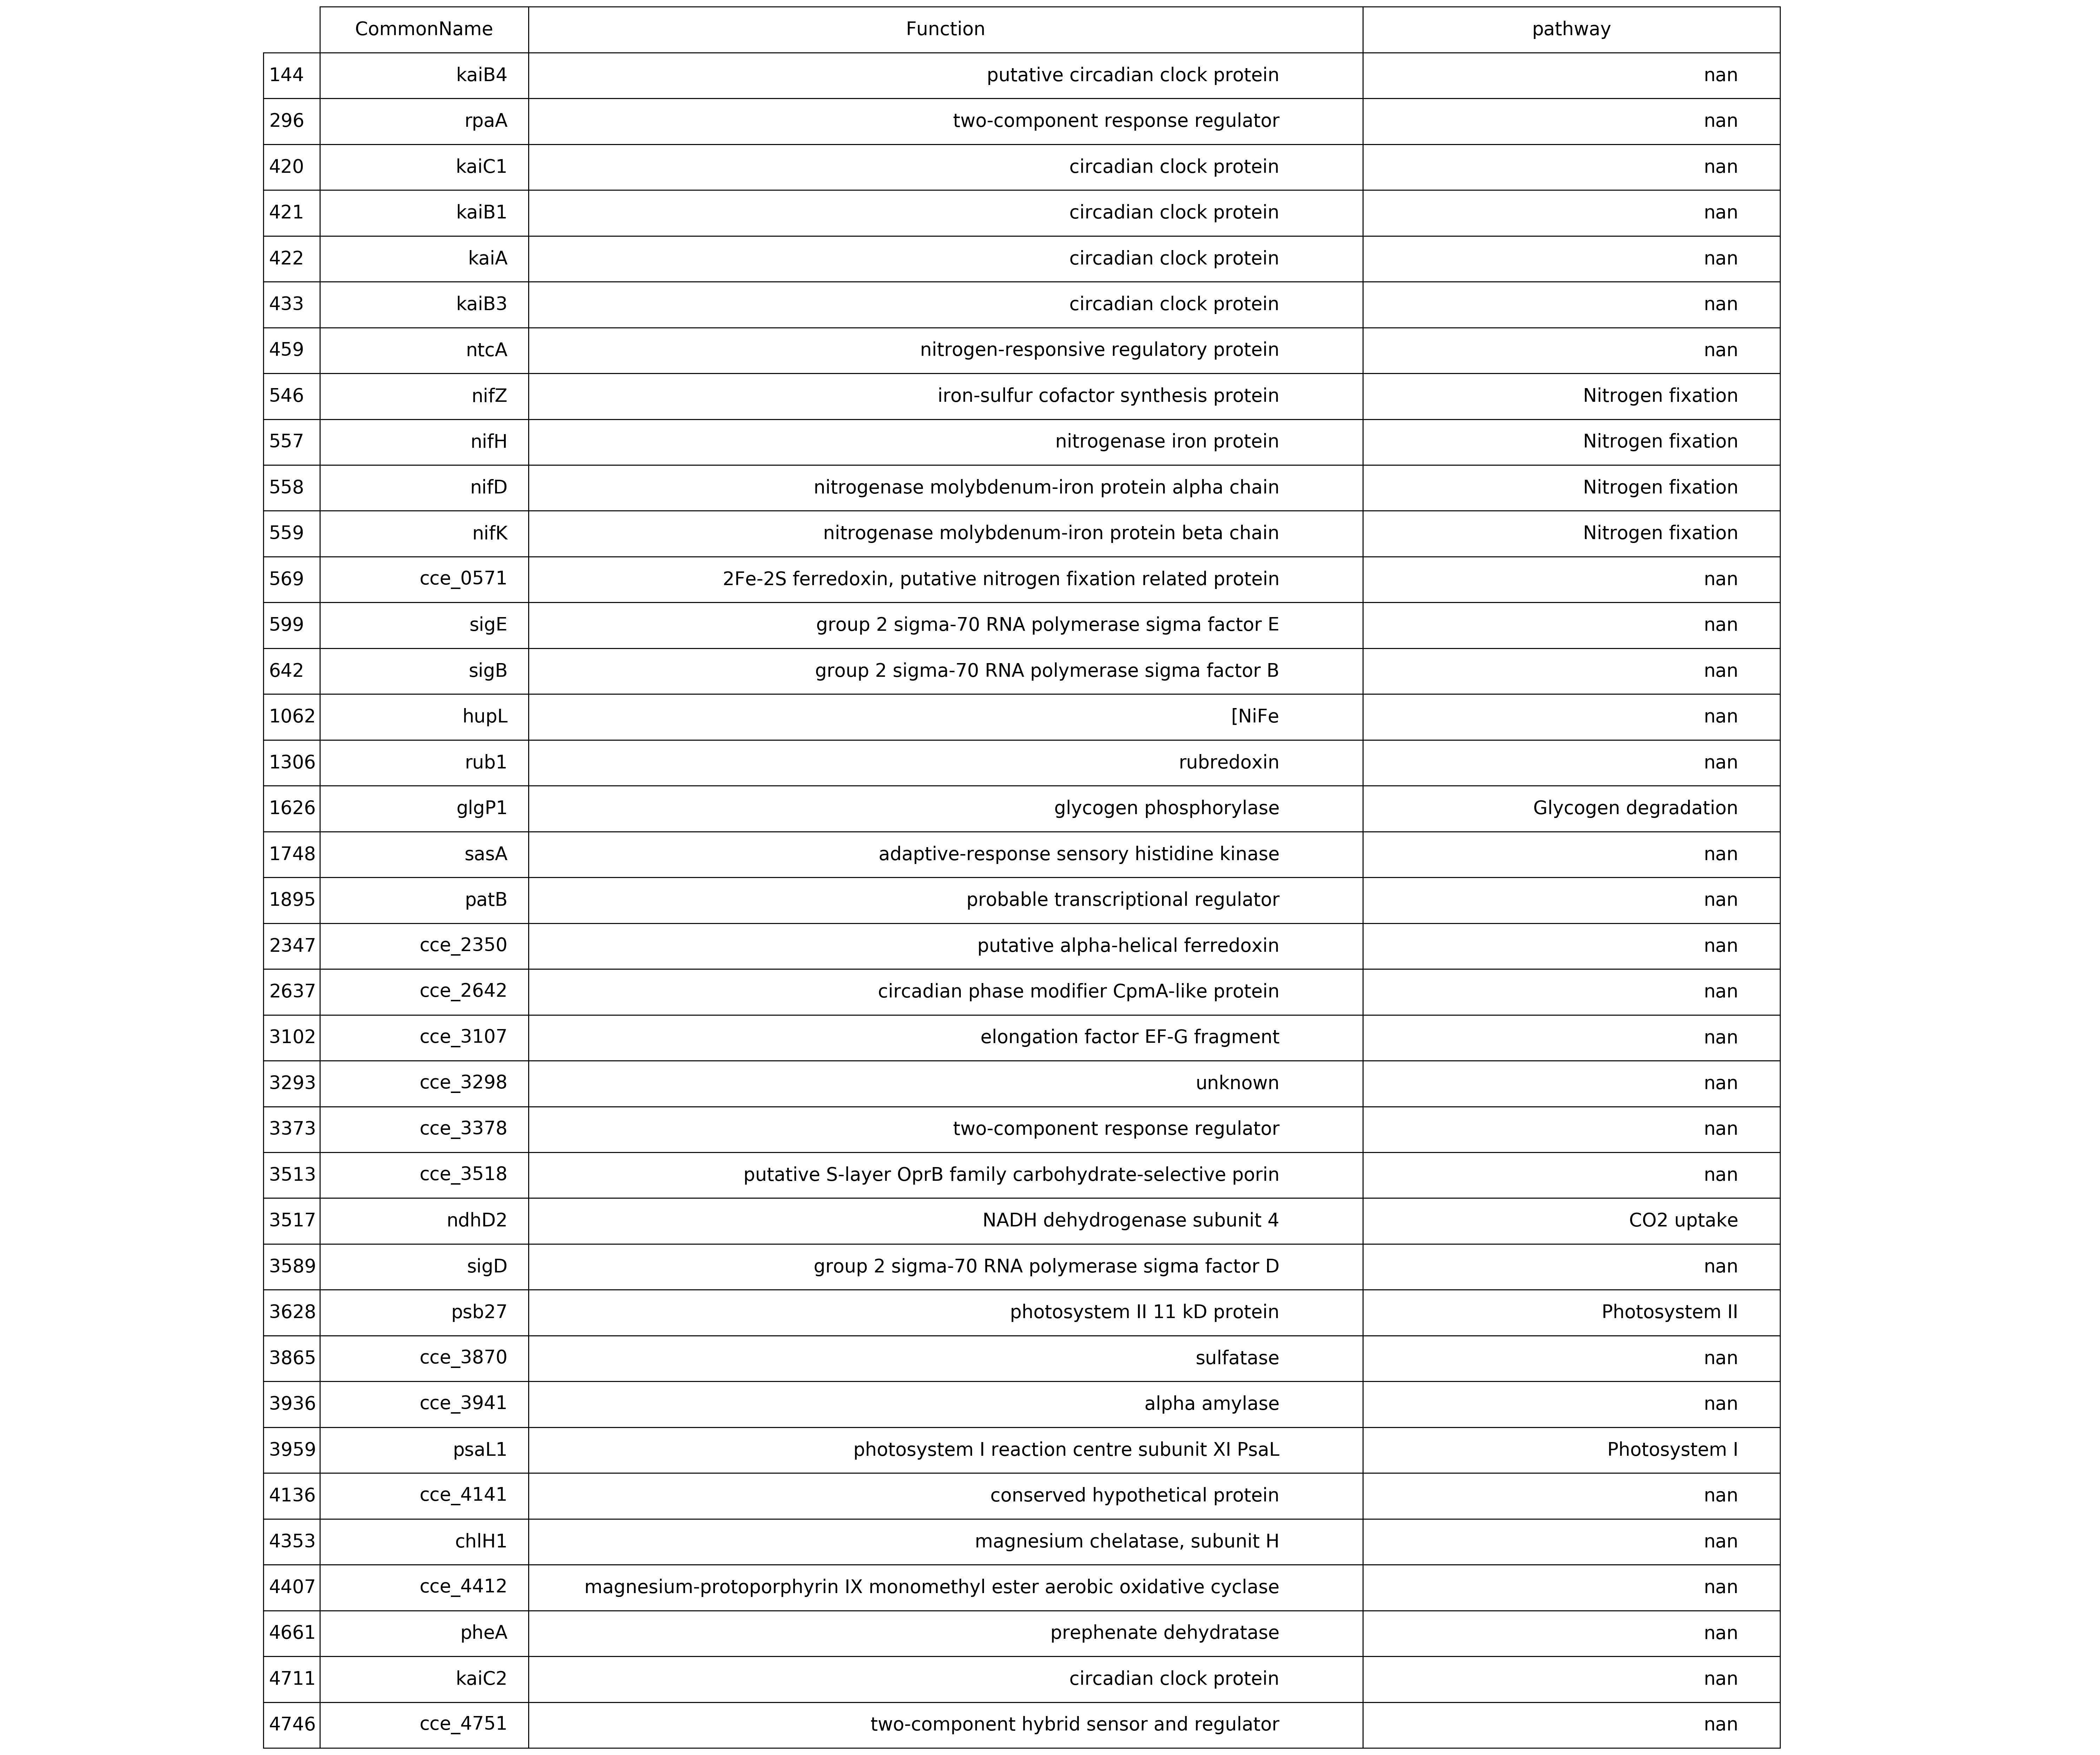

In [19]:
fig = plt.figure(figsize = (30,20),dpi=200)
ax = plt.subplot(111,frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
ax.axis('tight')
tab = table(ax, dfc,loc='center',colWidths=[0.05, 0.2, 0.1])  # where df is your data frame
tab.set_fontsize(45)
tab.scale(2,3)

plt.tight_layout()
plt.savefig('GRNimages/cGRNtable.png',bbox_inches = 'tight')

In [20]:
dfd1 = dfd.iloc[:33]
dfd2 = dfd.iloc[33:]

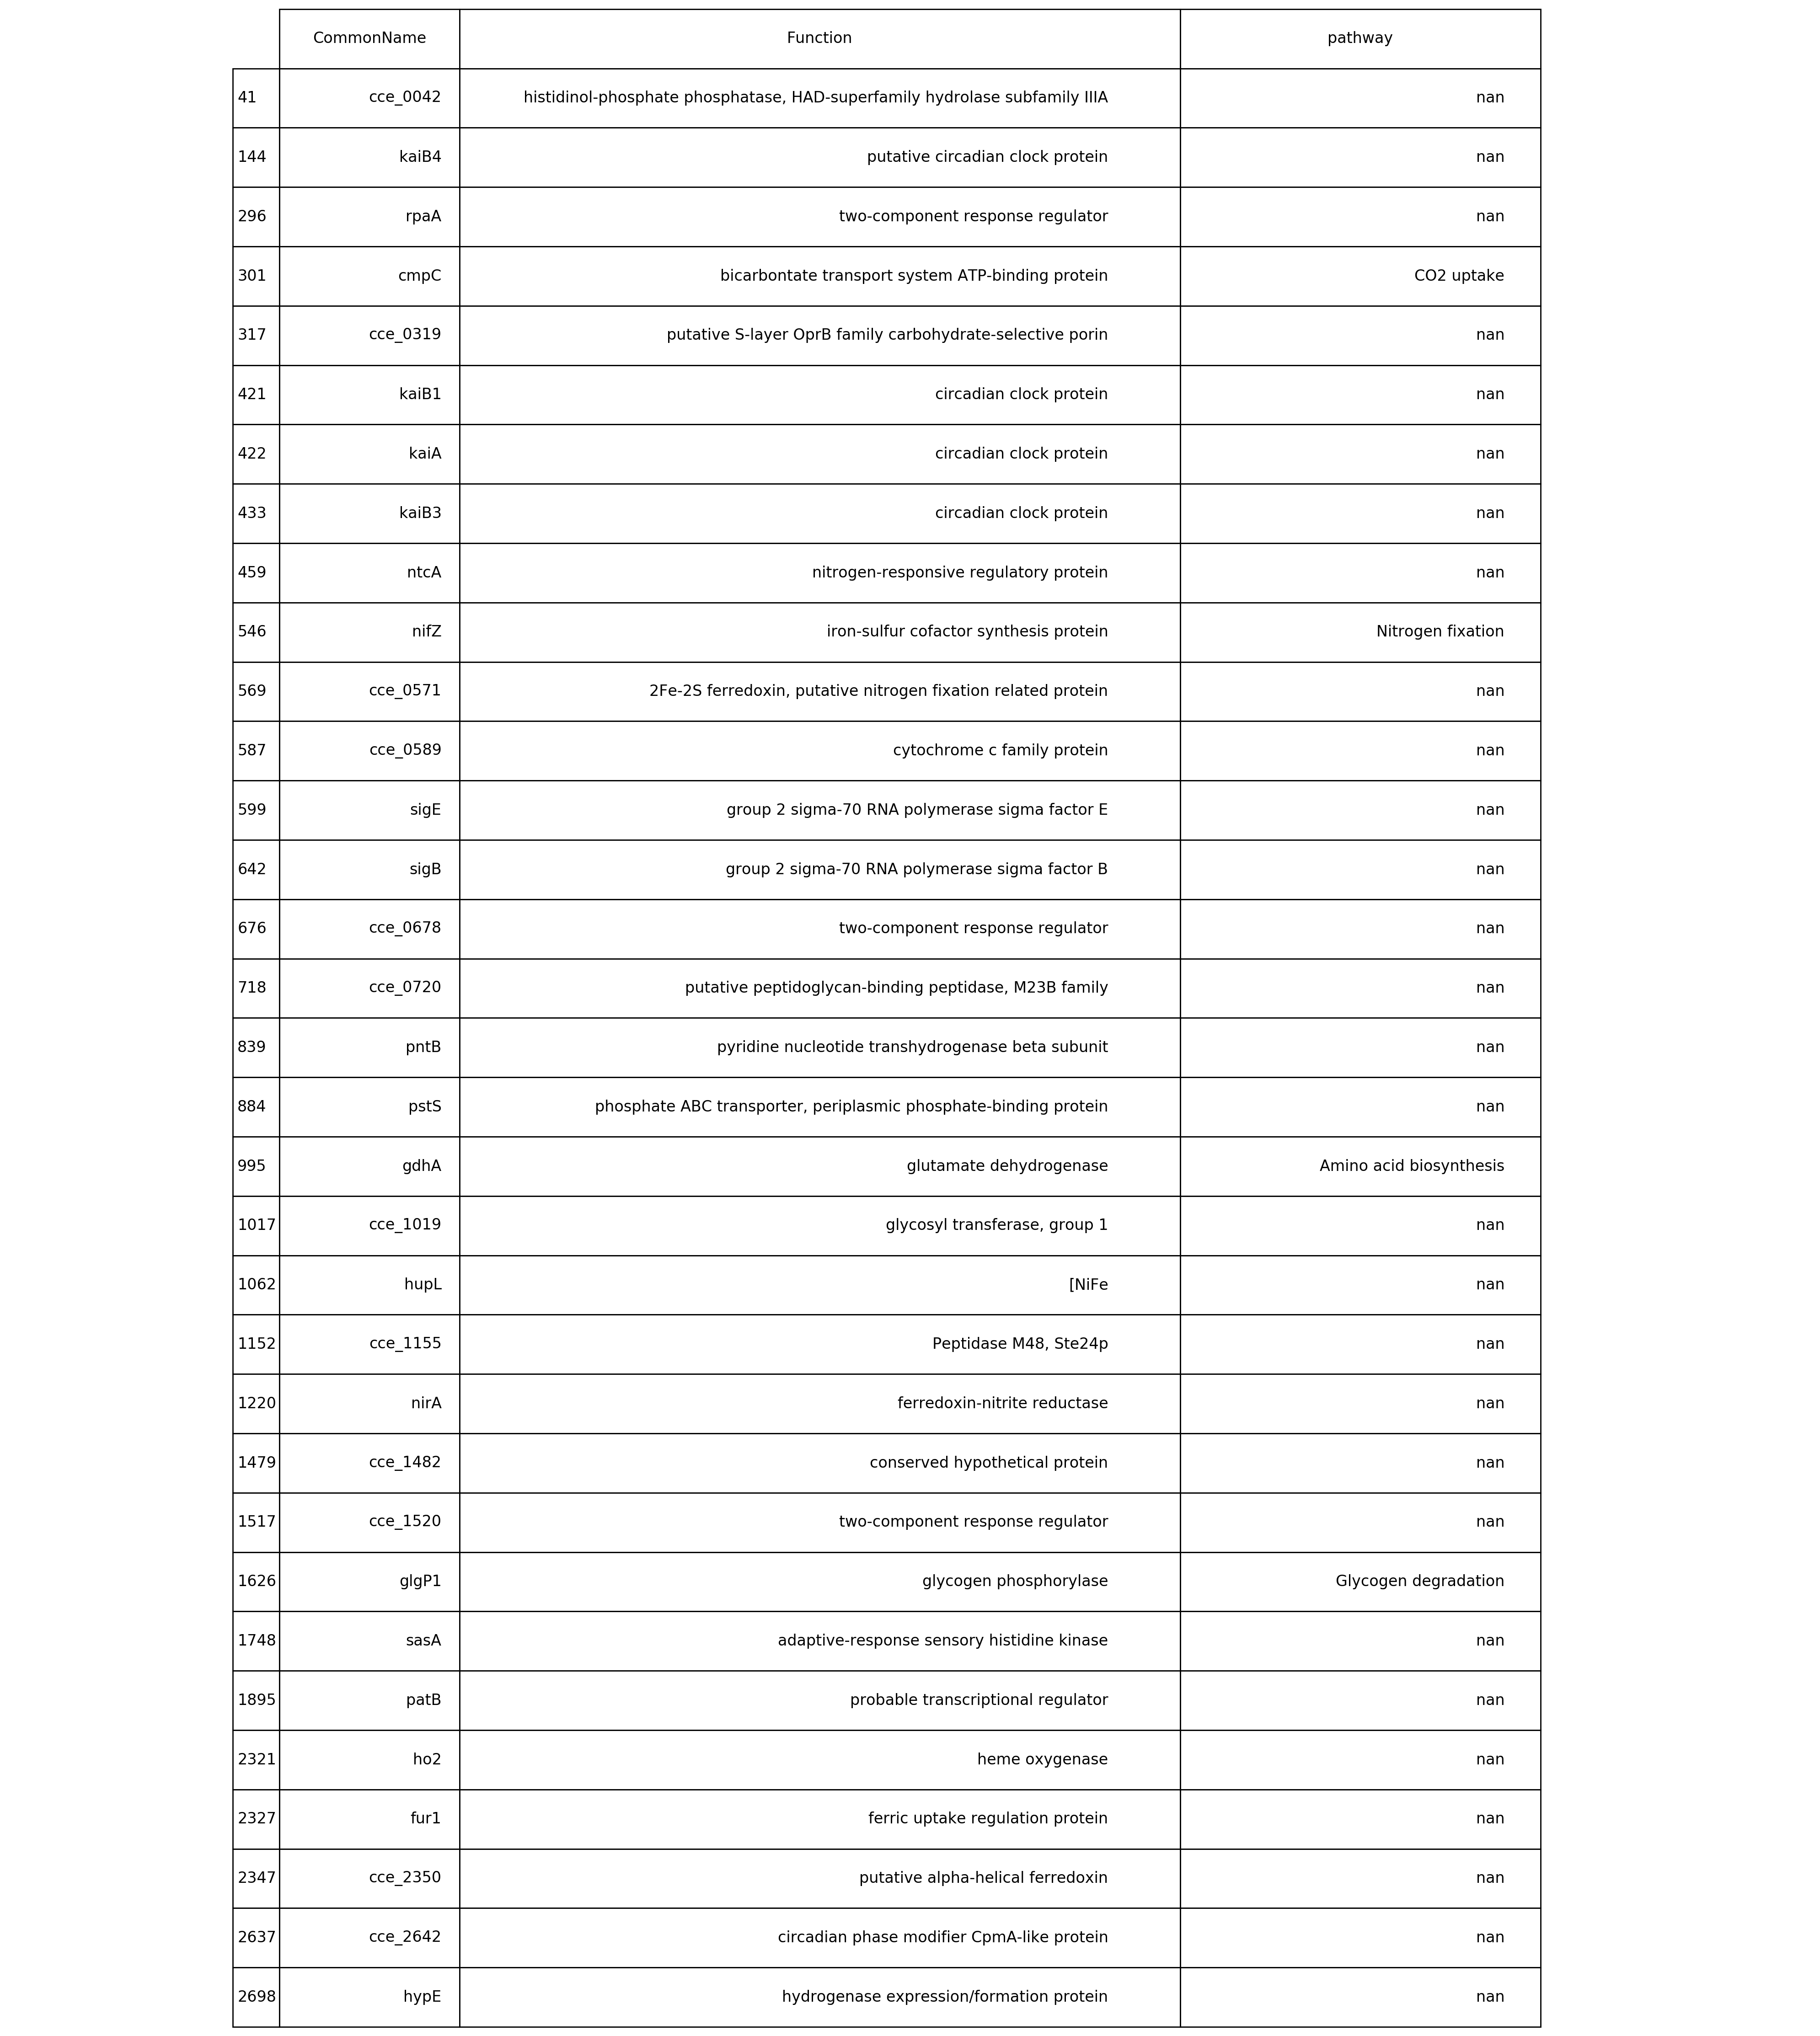

In [21]:
fig = plt.figure(figsize = (20,15),dpi=200)
ax = plt.subplot(111,frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
ax.axis('tight')
tab = table(ax, dfd1,loc='center',colWidths=[0.05, 0.2, 0.1])  # where df is your data frame
tab.set_fontsize(45)
tab.scale(2,3)

plt.tight_layout()
plt.savefig('GRNimages/dGRNtable1.png',bbox_inches = 'tight')

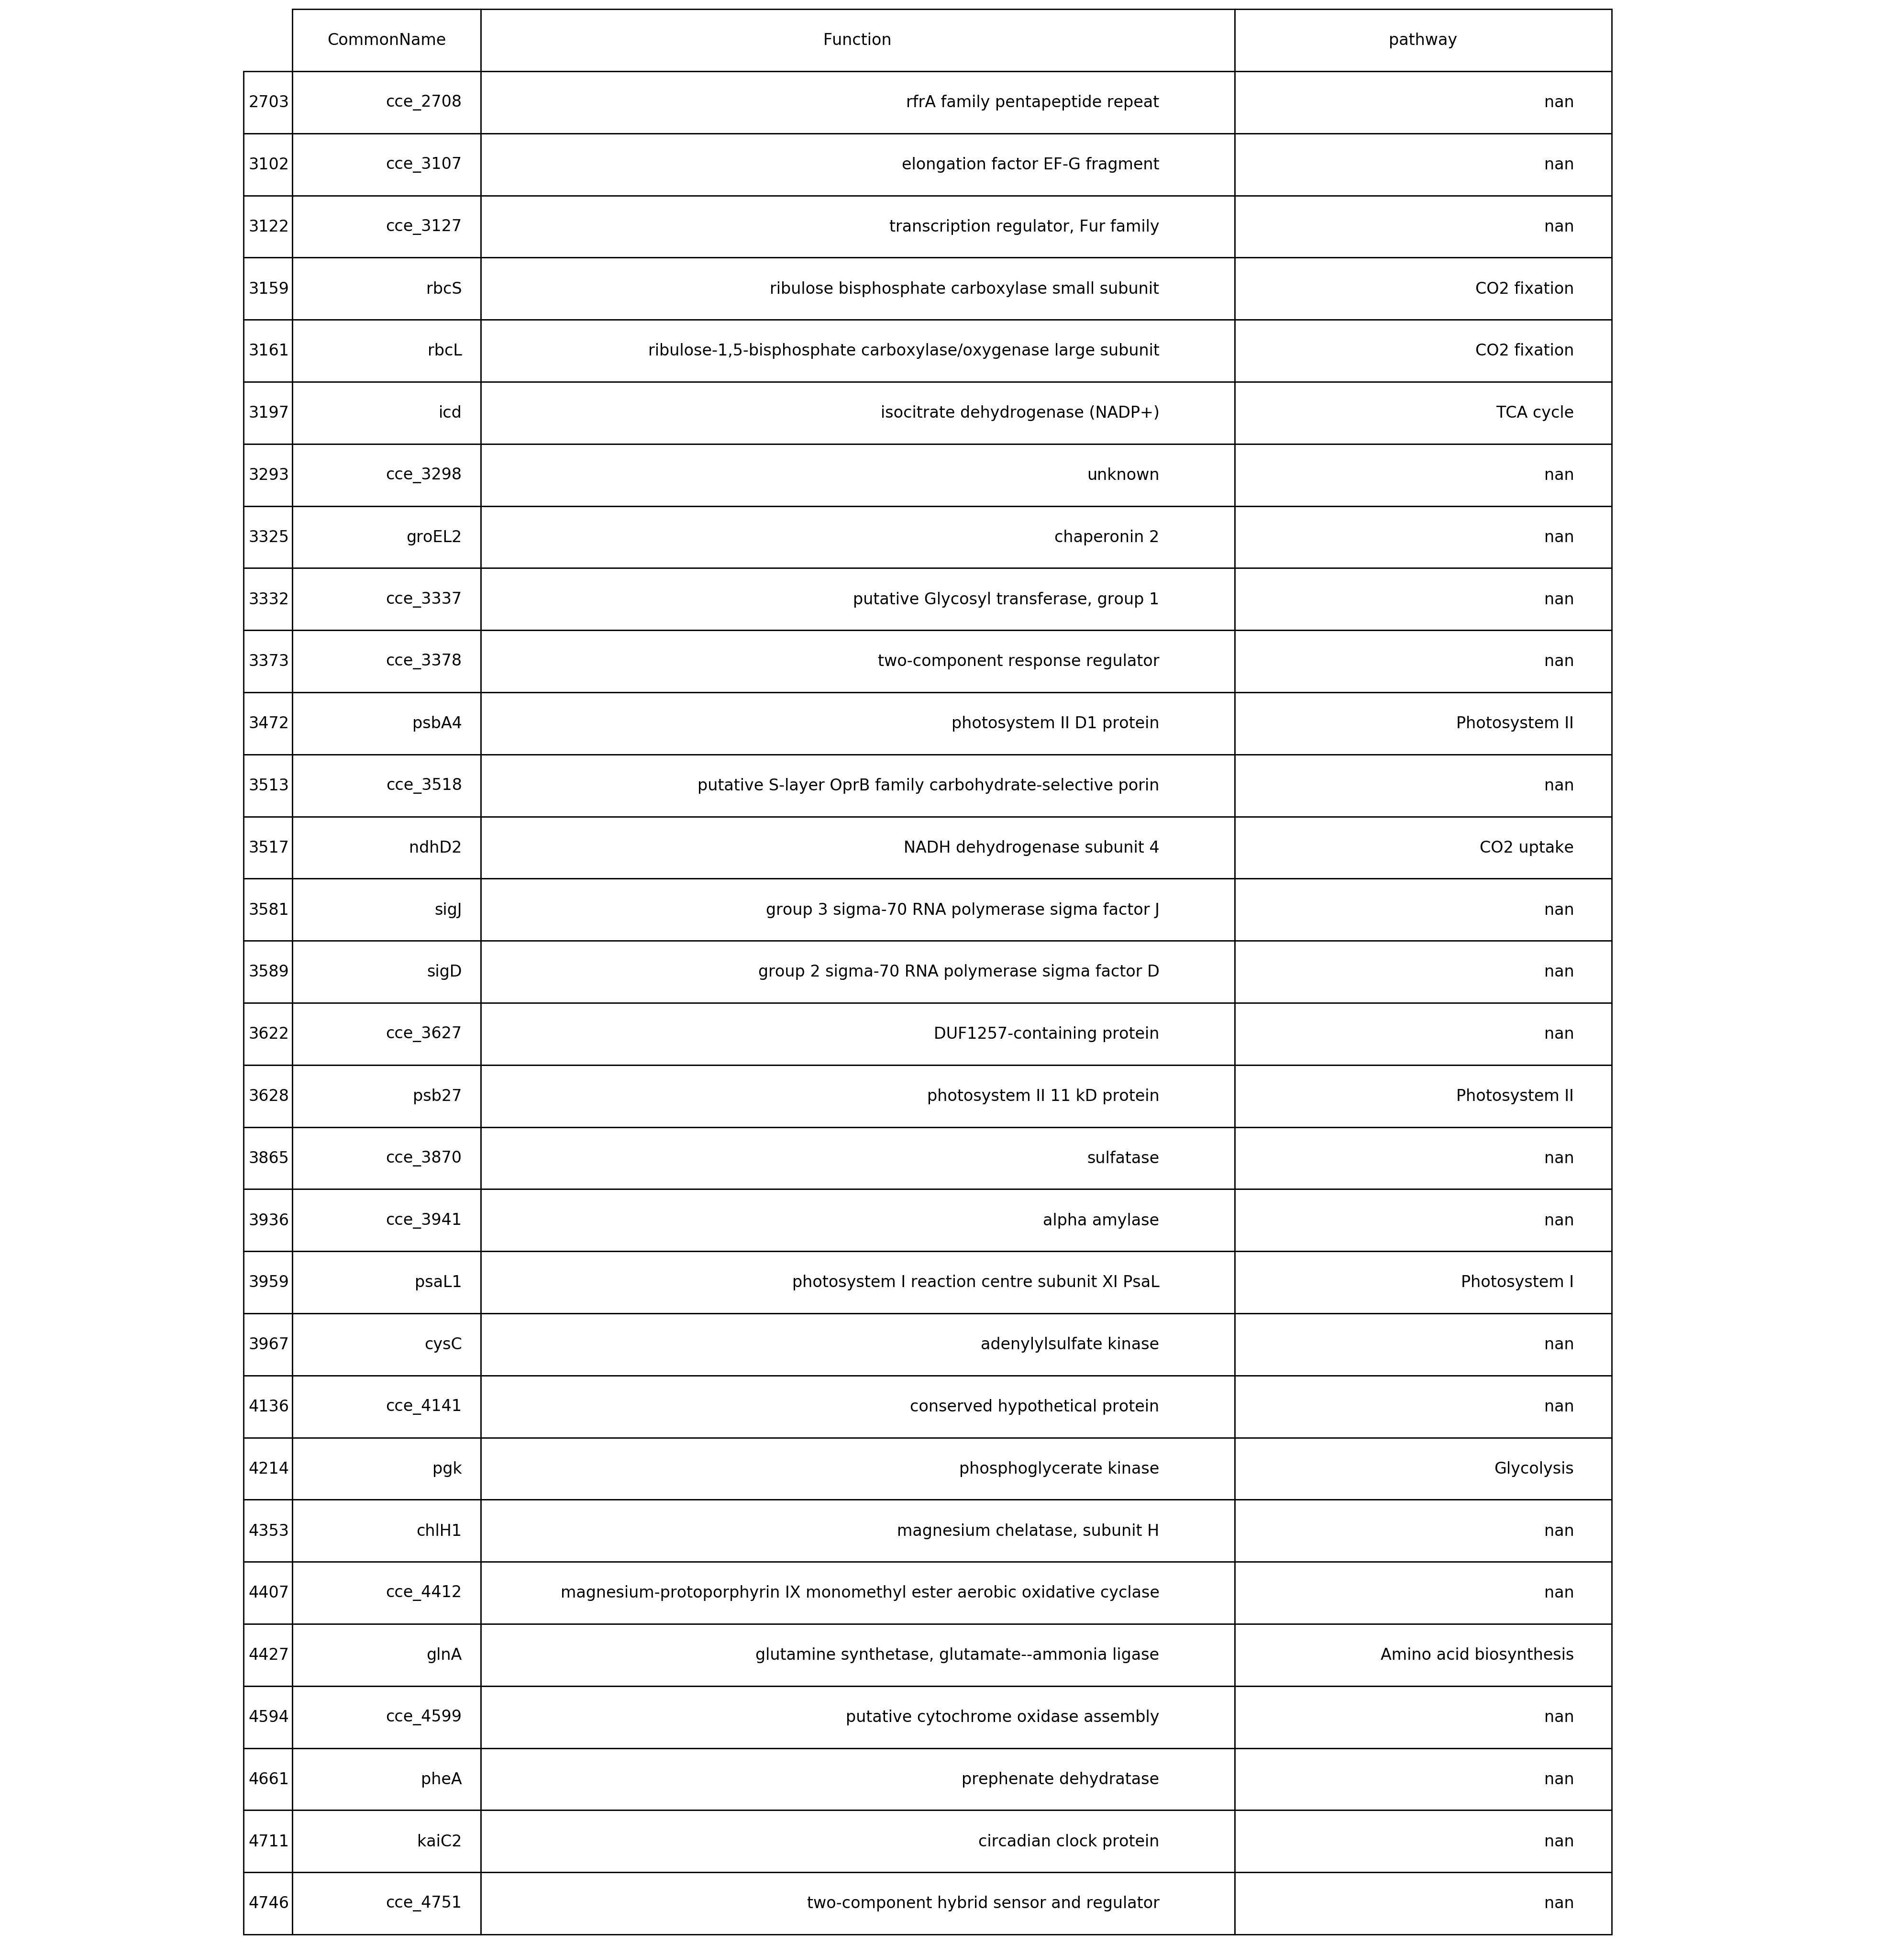

In [22]:
fig = plt.figure(figsize = (20,15),dpi=200)
ax = plt.subplot(111,frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
ax.axis('tight')
tab = table(ax, dfd2,loc='center',colWidths=[0.05, 0.2, 0.1])  # where df is your data frame
tab.set_fontsize(45)
tab.scale(2,3)

plt.tight_layout()
plt.savefig('GRNimages/dGRNtable2.png',bbox_inches = 'tight')

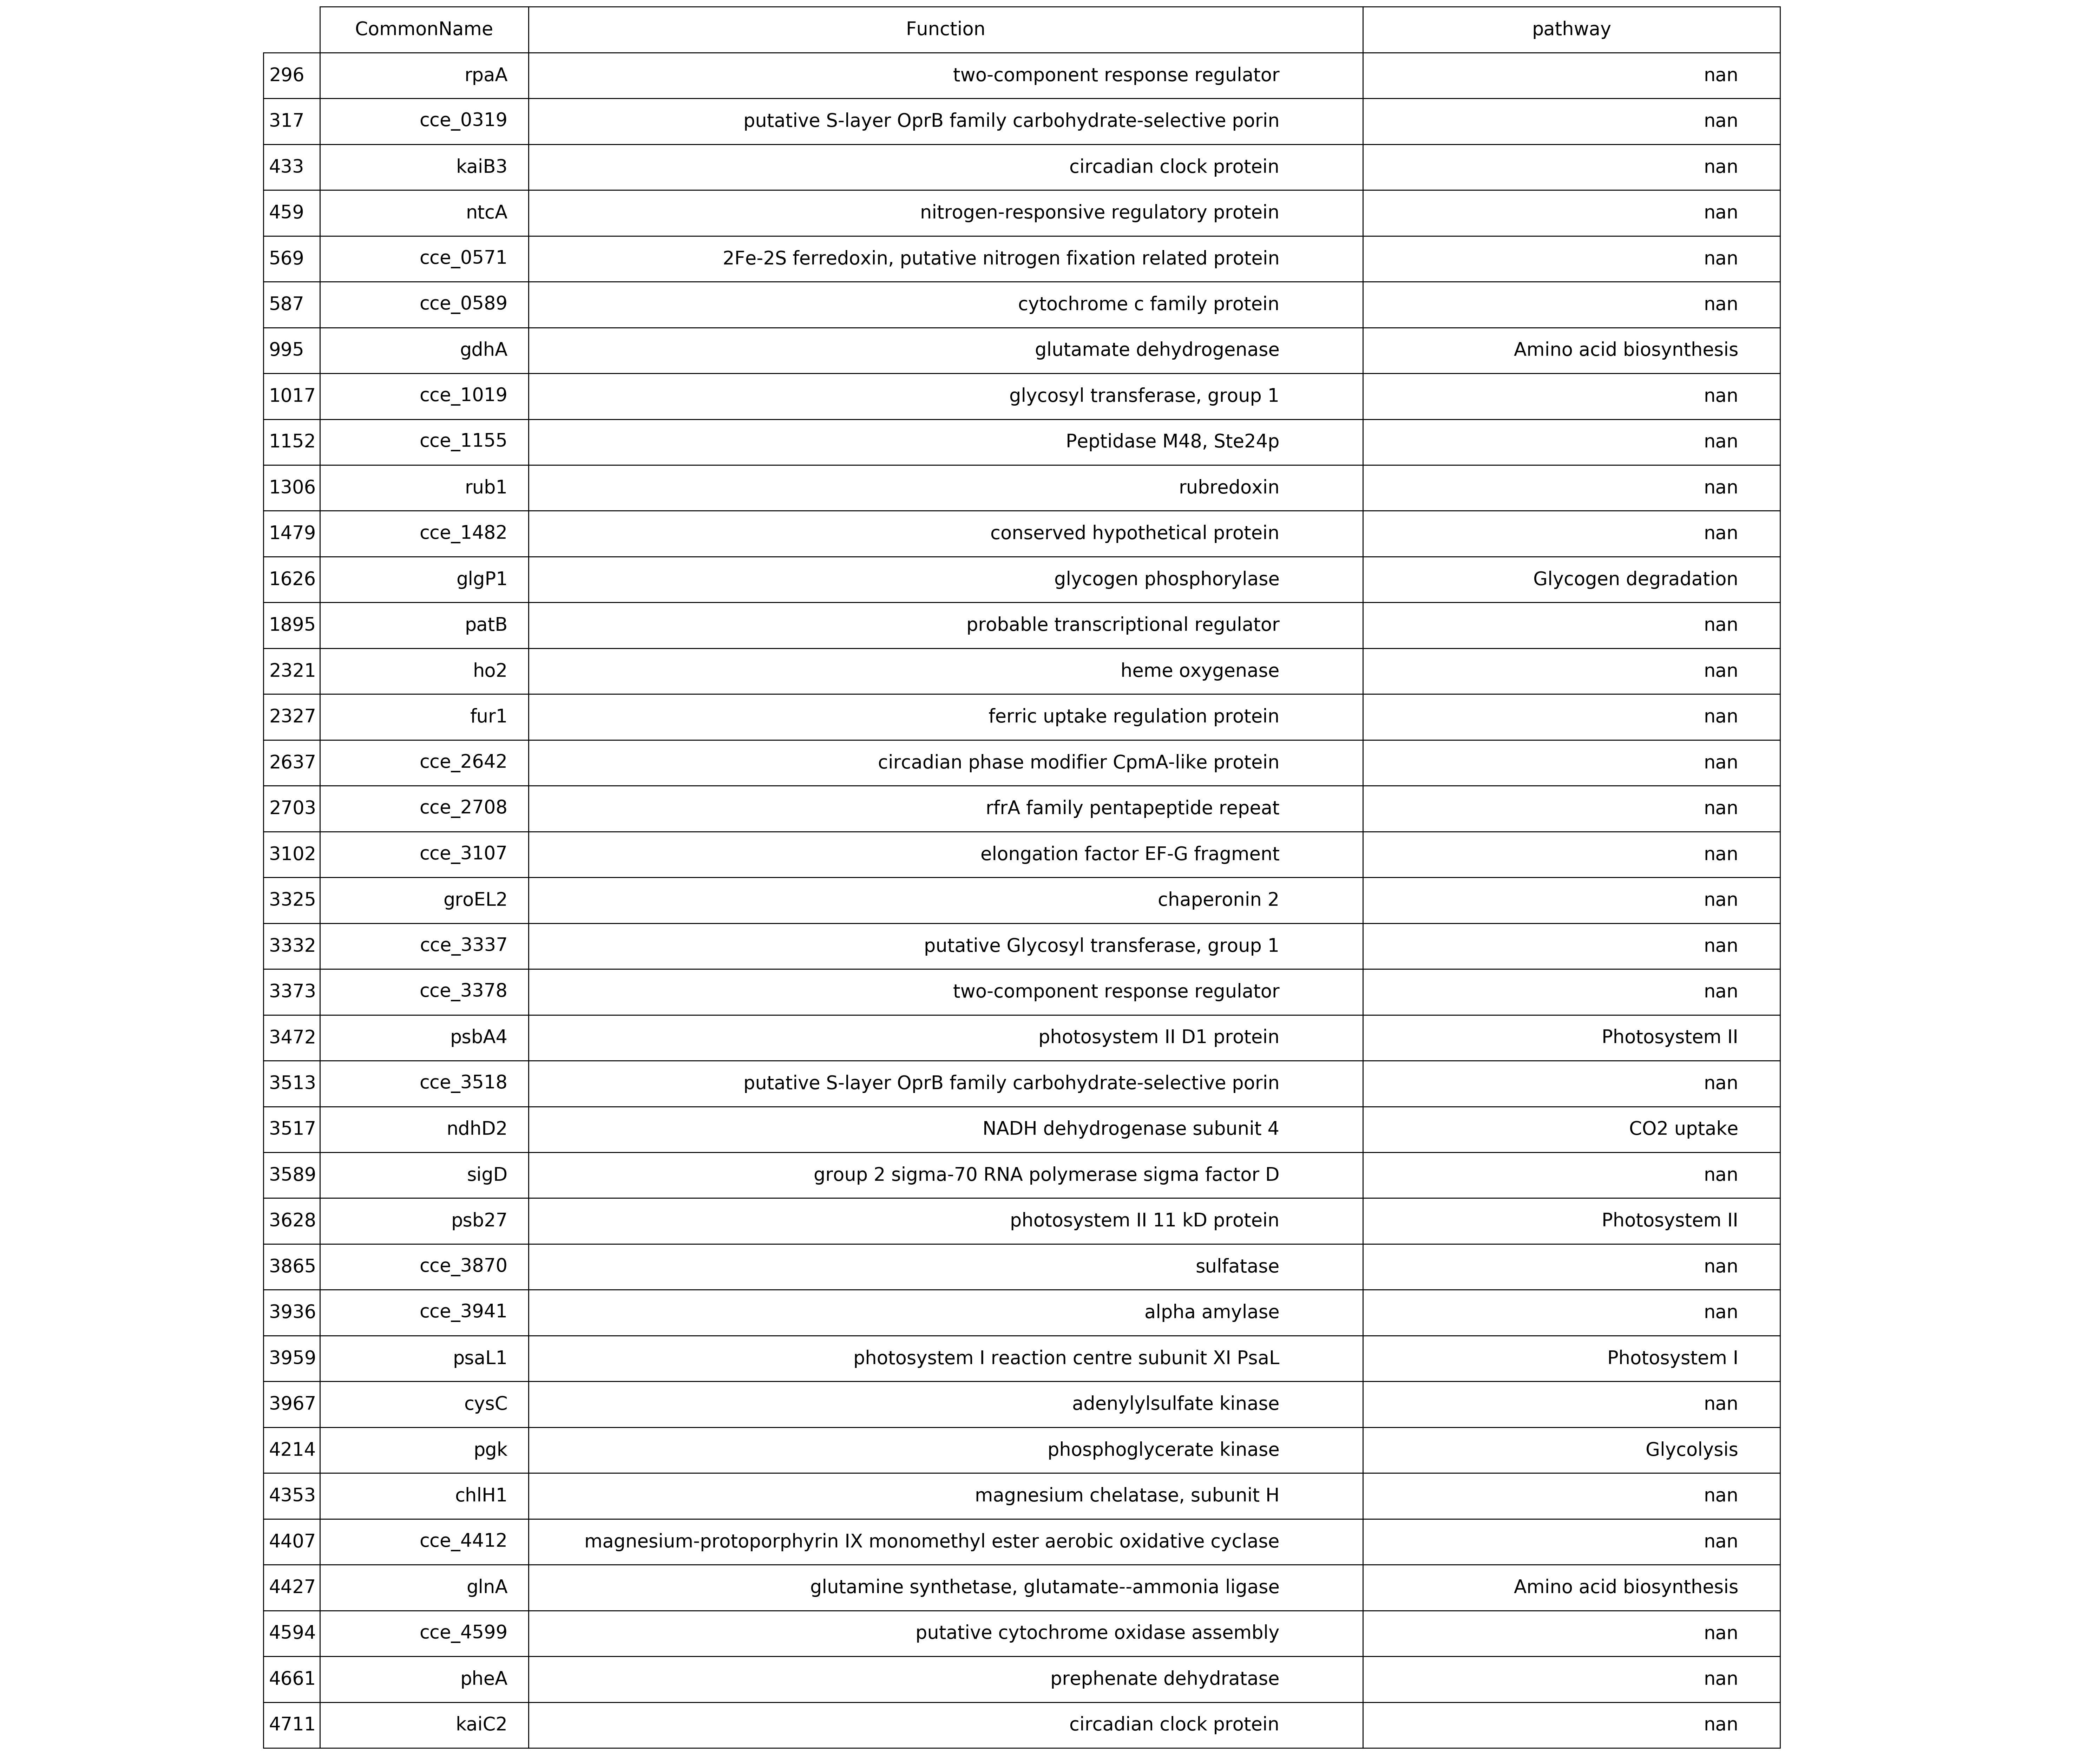

In [23]:
fig = plt.figure(figsize = (30,20),dpi=200)
ax = plt.subplot(111,frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
ax.axis('tight')
tab = table(ax, dff,loc='center',colWidths=[0.05, 0.2, 0.1])  # where df is your data frame
tab.set_fontsize(45)
tab.scale(2,3)

plt.tight_layout()
plt.savefig('GRNimages/fGRNtable.png',bbox_inches = 'tight')